# La présence de bibliothèques autour des lycées augmente-t-elle la performance des lycées ?

In [46]:
# Setup

# Si la commande n'avait pas déjà été lancée danas le terminal
!pip install -r "requirements.txt"

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from plotnine import *

pd.set_option('display.width', 140)

### Contexte

La performance des lycées est ici entendue comme le taux de réussite à l’examen du 
baccalauréat général, même si l’étude du taux de mention obtenu par les lycées est 
une piste envisagée. Celle-ci peut être expliquée par trois facteurs :

-	par le public de l’établissement (les élèves et leur origine sociale)
-	par le contexte de l’établissement (ses propriétés intrinsèques et possiblement les politiques 
    éducatives dont il fait objet)
-	par l’environnement de l’établissement (ce qui est relatif à sa situation géographique)

La question que l’on se pose se concentre sur les facteurs environnementaux de réussite scolaire, 
en proposant l’analyse de l’impact de la présence de bibliothèques autour des lycées. Les 
bibliothèques, qu’elles soient municipales, universitaires ou d’une autre nature, sont en effet 
des lieux qui peuvent favoriser la réussite des élèves par au moins deux moyens : d’abord, ce 
sont des lieux d’accès à la culture et à la connaissance ; d’autre part, ce sont aussi des 
lieux de révision privilégiés, notamment pour la préparation du baccalauréat .

La démarche adoptée consiste donc principalement à étudier le lien entre proximité d’une (ou de) 
bibliothèque(s) et performance des lycées. Cette proximité sera évaluée par la distance 
géographique, ou aussi par le nombre d’équipements disponibles dans un rayon donné. 


**Problématique**\
Dès lors, la question centrale de ce projet est la suivante : la proximité des bibliothèques autour des lycées est-elle associée à de meilleures performances au baccalauréat général, toutes choses égales par ailleurs ?

L’objectif est ainsi d’évaluer dans quelle mesure la présence et le nombre de bibliothèques à proximité d’un lycée contribuent à expliquer les différences observées de performance scolaire, une fois contrôlés les facteurs sociaux et institutionnels.

### Méthodes

@bourdieuHeritiersEtudiantsCulture1964

Après quelques statistiques descriptives et cartes pour illustrer le problème, des régressions 
linéaires seront mobilisées pour tester notre hypothèse, en contrôlant par d’autres variables. En 
partant des facteurs mis en évidence précédemment, la composition sociale du lycée sera appréciée 
à partir de l’indice de position sociale proposée par la Depp (cf. rubrique « Données »). Le 
contexte de l’établissement sera surtout pris en compte par le secteur de l’établissement 
(privé / public) et les filières et formations disponibles en son sein (filières technologiques 
et professionnelles, formations post-baccalauréat comme les BTS ou CPGE).

### Données

Pour ce qui est des données mobilisées, l’échelle d’observation sera le lycée. Le champ d’étude 
est limité aux lycées avec au moins 50 candidats (seuil à préciser) présents aux épreuves du 
baccalauréat général en 2024. Il s’agira alors de construire nos observations à partir de 
trois bases de données ouvertes produites par la Depp (service statistique ministériel de 
l’Education nationale) :
-	taux de réussite et de mention au bac (https://data.education.gouv.fr/explore/dataset/fr-en-indicateurs-de-resultat-des-lycees-gt_v2/information/)
-	indice de position sociale (https://data.education.gouv.fr/explore/dataset/fr-en-ips-lycees-ap2023/information/)
-	géolocalisation des lycées (https://data.education.gouv.fr/explore/dataset/fr-en-adresse-et-geolocalisation-etablissements-premier-et-second-degre/information/)

Enfin, nous utilisons le répertoire du Catalogue collectif de France pour récupérer l’ensemble des bibliothèques de France. Il est disponible sur le site de la Bibliothèque nationale de France (https://api.bnf.fr/index.php/fr/CCFr/Repertoire_Bibliotheques).


## Analyse descriptive des données

### Les données sur les lycées

In [47]:
# Importation des données sur les lycées

from src.data_lycees import get_data_lycees
from src.data_lycees import merge_data_lycees
from src.data_lycees import filter_data_lycees

lycees_resultats, lycees_ips, annuaire_education = get_data_lycees()
lycees_data_0 = merge_data_lycees(lycees_resultats, lycees_ips, annuaire_education)
lycees_data = filter_data_lycees(lycees_data_0)

/home/onyxia/work/ensae-pythonds/src/data_lycees.py:241: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
/home/onyxia/work/ensae-pythonds/src/data_lycees.py:242: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
/home/onyxia/work/ensae-pythonds/src/data_lycees.py:243: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.


Pour rappel, les données sur les lycées ont été obtenues sur le site de l'Education 
nationale française ([data.education.gouv.fr](https://data.education.gouv.fr)). Trois 
jeux de données complémentaires sont mobilisés et joints successivement sur l'UAI. Dans l'ordre d'utilisation :

-   *Indicateurs de résultats des lycées*
([lien direct vers la source](https://data.education.gouv.fr/explore/dataset/fr-en-indicateurs-de-resultat-des-lycees-gt_v2/information/))
-   *Indices de position sociale des lycées*
([lien direct vers la source](https://data.education.gouv.fr/explore/dataset/fr-en-ips-lycees-ap2023/information/))
-   *Annuaire de l'éducation*
([lien direct vers la source](https://data.education.gouv.fr/explore/dataset/fr-en-annuaire-education/information))

Pour récupérer la densité de la commune du lycée, la base *Communes et villes de France* est téléchargée depuis [data.gouv.fr](https://www.data.gouv.fr) 
([lien direct vers la source](https://www.data.gouv.fr/datasets/communes-et-villes-de-france-en-csv-excel-json-parquet-et-feather/informations)).

A l'import des données, pour des questions de représentativité et de simplicité, on se restreint aux lycées
qui satisfont aux deux conditions suivants :
-   au moins 50 candidats étaient présents à l'examen du baccalauréat général
-   le lycée est situé en Hexagone (hors Corse)

Au final, on obtient une base de données avec 1911 lycées.

In [48]:
# Lycées table

lycees_data

,index,uai,annee,presents_gnle,taux_reu_gnle,taux_men_gnle,ips_voie_gt,ecart_type_voie_gt,libelle_etablissement,position,...,voie_professionnelle,section_arts,section_cinema,section_theatre,section_sport,section_internationale,section_europeenne,post_bac,grille_densite_texte,grille_densite_4
0,0,0010006B,2024,104.0,98.0,63.0,99.2,32.0,Lycée polyvalent Saint-Exupéry,POINT (917623.9 6560849.305),...,1,1,0,0,0,0,1,1,Centres urbains intermédiaires,Centres urbains intermédiaires
1,1,0010010F,2024,145.0,92.0,62.0,110.2,33.0,Lycée polyvalent du Bugey,POINT (909024.7 6521619.905),...,1,1,0,0,1,0,1,0,Petites villes,Petites villes
2,2,0010013J,2024,330.0,99.0,81.0,123.7,35.1,Lycée Lalande,POINT (871577.8 6569320.405),...,0,1,1,1,0,0,1,1,Centres urbains intermédiaires,Centres urbains intermédiaires
3,3,0010014K,2024,234.0,94.0,59.0,108.6,32.9,Lycée Edgar Quinet,POINT (871668.3 6568818.605),...,0,1,1,1,0,0,1,1,Centres urbains intermédiaires,Centres urbains intermédiaires
4,4,0010016M,2024,233.0,96.0,59.0,110.6,33.7,Lycée polyvalent Joseph-Marie Carriat,POINT (871495.2 6568856.805),...,1,1,1,1,1,0,1,1,Centres urbains intermédiaires,Centres urbains intermédiaires
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1906,2208,0951994B,2024,55.0,100.0,62.0,120.3,30.8,Lycée polyvalent privé ORT,POINT (656814 6877316.404),...,1,0,0,0,0,0,0,0,Grands centres urbains,Grands centres urbains
1907,2209,0952158E,2024,59.0,97.0,64.0,121.5,32.3,Lycée Paul Ricoeur,POINT (664045.3 6882755.904),...,0,0,0,0,0,0,0,0,Centres urbains intermédiaires,Centres urbains intermédiaires
1908,2210,0952173W,2024,136.0,85.0,31.0,93.6,30.8,Lycée Paulette Nardal,POINT (642504.5 6869354.704),...,1,0,0,1,0,0,1,0,Grands centres urbains,Grands centres urbains
1909,2211,0952196W,2024,342.0,92.0,60.0,115.1,36.5,"Lycée polyvalent Gustave Monod, Lycée des méti...",POINT (648440.5 6874902.404),...,1,0,0,1,0,0,1,1,Grands centres urbains,Grands centres urbains


Dans notre jeu de données, on dispose ainsi de plusieurs variables importantes pour notre analyse :

-   les *variables de* "*performance*", que l'on cherche à expliquer
    +   Le taux de réussite au baccalauréat général (`taux_reu_gnle`) : pourcentage d’élèves présents aux épreuves du baccalauréat général ayant obtenu le diplôme
    +   Le taux de mention au baccalauréat général (`taux_men_gnle`) : pourcentage d’élèves ayant obtenu une mention (Assez Bien, Bien ou Très Bien)

-   les *variables de composition sociale*, qui seront importantes à prendre en compte en tant que variables de contrôle
    +   Note préalable : l'Indice de Position Sociale (IPS) est d'abord calculé individuelle. A partir des résultats nationaux et des professions des parents des élèves, l'IPS synthétise la position sociale des élèves et correspond à peu près à la performance attendu d'un élève compte tenu son origine sociale (nous y reviendrons plus tard). Cet IPS individuel n'est pas public et on dispose uniquement d'indicateurs agrégés.
    +   La moyenne de l'IPS dans l'établissement (`ips_voie_gt`) : plus l’IPS moyen est élevé, plus le public accueilli est socialement favorisé
    +   L'écart-type de l'IPS dans l'établissement (`ecart_type_voie_gt`) : plus cet écart-type est élevé, plus le lycée concerné fait face à un public plus divers socialement.

-   des *variables renseignant sur les formations ou filières* disponibles dans le lycée
    +   la présence de filières technologiques (`voie_technologique`) 
    +   la présence de filières professionnelles (`voie_professionnelle`) 
    +   la présence d'une section européenne (`section_europeenne`) 
    +   la présence de formation post-bac, comme les CPGE ou les BTS (`post_bac`) 

-   des *métadonnées sur l'établissement*
    +   son nom (`libelle_etablissement`)
    +   son statut (`statut_public_prive`)
    +   son inscription géographique large (`nom_commune`, `libelle_departement`, `libelle_academie`, `libelle_region`)
    +   la densité de la commune en 7 catégories (`grille_densite_texte`)
    +   la densité de la commune en 4 catégories (`grille_densite_4`) : à partir de , pour avoir des effectifs plus importants, ont été regroupé les catégories "Rural à habitat très dispersé" et "Rural à habitat dispersé" dans la catégorie "Bourgs ruraux" ; même chose pour les villes des "Ceintures urbaines" et qui ont rejoint les "Petites villes"


Jetons un coup d'œil rapide sur les données pour mieux comprendre la forme des données. 

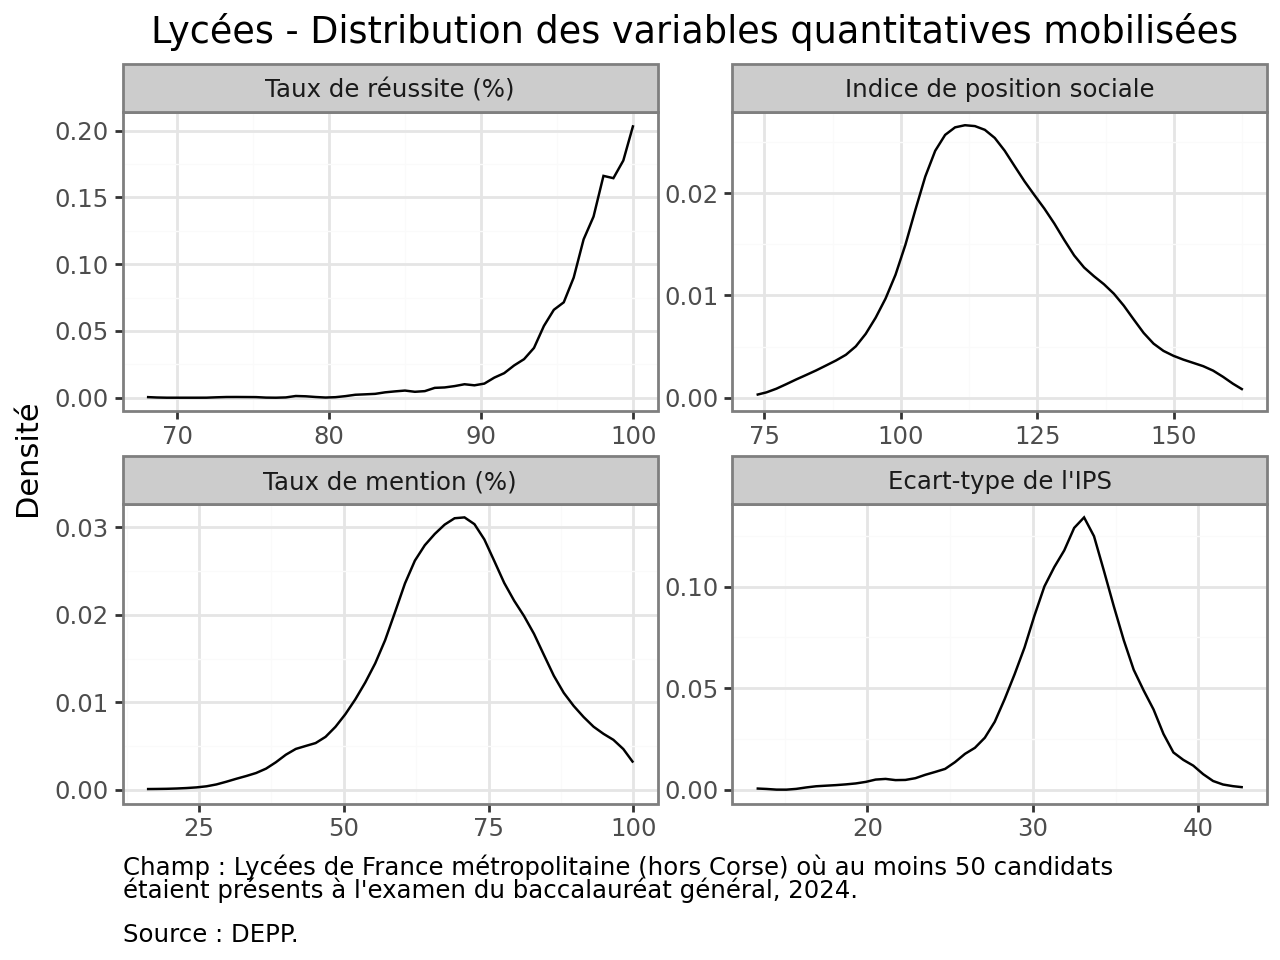

In [49]:
# Stats desc. - Lycées vars numériques

from src.stats_desc import lycees_stat_desc_num

plot_champ = "Lycées de France métropolitaine (hors Corse) où au moins 50 candidats \nétaient présents à l'examen du baccalauréat général, 2024."
plot_source = "DEPP"

dat_lycees_stat_desc_num = lycees_stat_desc_num(lycees_data)
(
    ggplot(dat_lycees_stat_desc_num) +
    aes(x = 'value') +
    geom_density(n = 50) +
    facet_wrap('variable', scales = 'free') +
    theme_bw() +
    labs(
        x = "", y = "Densité",
        title = "Lycées - Distribution des variables quantitatives mobilisées",
        caption = f"Champ : {plot_champ}\n\nSource : {plot_source}."
    ) +
    theme(plot_caption = element_text(ha = "left"))
)


La densité du taux de réussite au baccalauréat général est fortement concentrée autour de valeurs élevées, avec un pic proche de 95–100 %. La distribution est peu dispersée et présente une asymétrie à gauche, traduisant un effet de plafond : la majorité des lycées atteignent un niveau de réussite élevé, tandis qu’un nombre restreint d’établissements affiche des performances nettement plus faibles.

À l’inverse, la densité du taux de mention est beaucoup plus étalée et présente une dispersion marquée. La distribution est asymétrique à droite, indiquant que si une majorité de lycées obtient des taux de mention intermédiaires, une fraction non négligeable d’établissements se distingue par des performances très élevées. 

L'hétérogénéité du taux de mention suggère qu'il constitue une mesure plus fine de la performance scolaire et permet de mieux discriminer les "bons" établissements des "mauvais". C'est pour cette raison que nous nous concentrerons sur cet indicateur par la suite.

Pour ce qui est de la moyenne de l'IPS, sa dispersion est relativement forte, même s'il est dur d'interpréter cette valeur qui n'a pas d'unité. Au sein des établissements, il est possible de remarqué que la variabilité de l'écart-type est aussi relativement importante.


In [50]:
# Stats desc. - Lycées vars catégorielles

(
    lycees_data
    .groupby(['grille_densite_4'])
    .size()
    .div(lycees_data.shape[0])
    .mul(100)
)


/tmp/ipykernel_20299/1276477359.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


grille_densite_4
Grands centres urbains            50.811094
Centres urbains intermédiaires    27.786499
Petites villes                    13.448456
Bourgs ruraux                      7.901622
dtype: float64

La plupart des lycées sont situés dans des communes relativement denses. Cela n'est pas très surprenant étant donné la concentration des services offerts à la population dans les grandes villes.

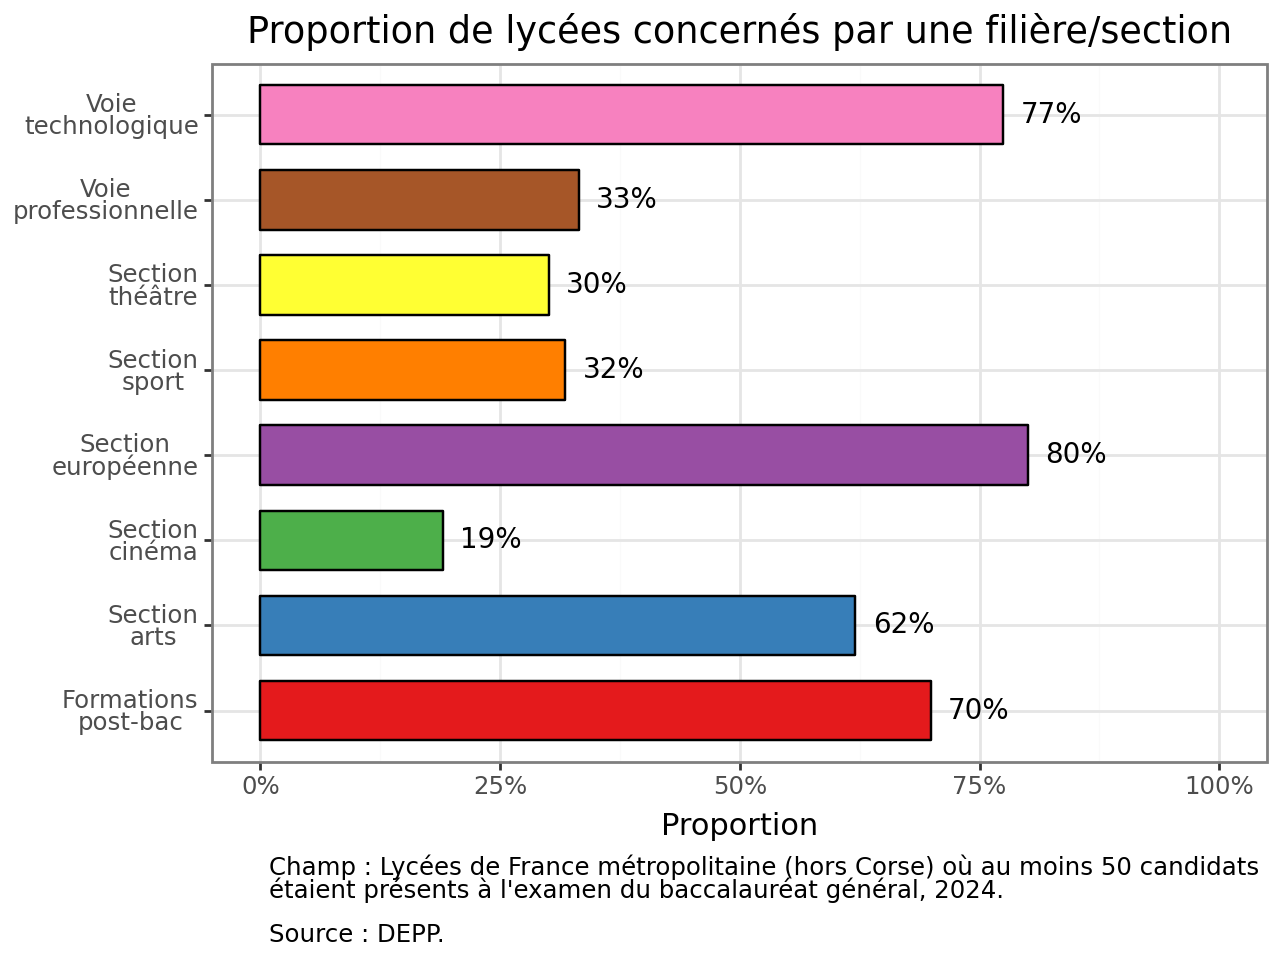

In [51]:
# Stats desc. - Lycées vars binaires

from src.stats_desc import lycees_stat_desc_bin
plot_champ = "Lycées de France métropolitaine (hors Corse) où au moins 50 candidats \nétaient présents à l'examen du baccalauréat général, 2024."
plot_source = "DEPP"

dat_lycees_stat_desc_bin = lycees_stat_desc_bin(lycees_data)

(
    ggplot(dat_lycees_stat_desc_bin, aes(x = 'variable', y = 'prop', fill = 'variable')) +
    geom_bar(stat = 'identity', color = 'black', width = 0.7) +
    geom_text(
        aes(label = 'prop'), format_string = '{:.0%}',
        nudge_y = 0.05, size = 10, color = 'black'
    ) +
    labs(
        title = 'Proportion de lycées concernés par une filière/section',
        x = '', y = 'Proportion',
        caption = f"Champ : {plot_champ}\n\nSource : {plot_source}."
    ) +
    scale_y_continuous(labels = lambda x: [f"{v:.0%}" for v in x]) +
    scale_fill_brewer(type = 'qual', palette = 'Set1') +
    coord_flip(ylim = [0, 1]) +
    theme_bw() +
    theme(legend_position='none')
)


Enfin, sur le plan des formations proposées **COMMENTER**

### Les données sur les bibliothèques

Pour rappel, les données sur les bibliothèques proviennent du répertoire du Catalogue collectif de France, disponible sur l'API de la Bibliothèque nationale de France ([lien direct](https://api.bnf.fr/index.php/fr/CCFr/Repertoire_Bibliotheques)).

L'avantage de cette source de données est de proposer des données géolocalisées. D'autres informations présentes sont également utiles pour spécifier les bibliothèques auxquelles on a affaire.


In [52]:
# Importation des données sur les bibliothèques

from src.data_biblio import get_data_biblio

biblio_0 = get_data_biblio()

In [53]:
# Biblio table

biblio_0

,NOMETAB,PAYS,CODEPOSTAL,LATITUDE,LONGITUDE,CONDITIONACCES_d,TYPEFAMABES_d,geometry
0,"Bibliothèque municipale. Lyon, Rhône",FR,69431,45.760940,4.857483,Tous publics,Bibliothèque Municipale,POINT (844367.27 6519624.236)
1,"Bibliothèque municipale. Baume-les-Dames, Doubs",FR,25110,47.351700,6.361317,Tous publics,Bibliothèque Municipale,POINT (953675.138 6699996.481)
2,Service des ressources documentaires. Rosières...,fr,10430,48.269882,4.062266,Accès réservé,Bibliothèque Universitaire,POINT (778817.499 6797146.375)
3,Muséum national d'histoire naturelle. Biblioth...,FR,75005,48.841528,2.357592,Tous publics,Bibliothèque Universitaire,POINT (652851.006 6860356.163)
4,"Médiathèque municipale. Rambervilliers, Vosges",FR,88700,48.345610,6.633583,Tous publics,Bibliothèque Municipale,POINT (969128.655 6811226.321)
...,...,...,...,...,...,...,...,...
5162,École supérieure d'art et de design. Bibliothèque,FR,72000,48.006405,0.196126,Tous publics,None,POINT (490957.439 6771047.259)
5163,Centre du réseau Sudoc PS Nouvelle Aquitaine -...,FR,33608,46.036636,2.636719,None,Bibliothèque Universitaire,POINT (671903.429 6548606.93)
5164,France. Service historique de la Défense. Pau,FR,64000,43.298582,-0.378599,Tous publics,Bibliothèque Spécialisée,POINT (425763.684 6250247.3)
5165,"Musée Alexandre Dumas. Villers-Cotterêts, Aisne",fr,02600,49.253033,3.089553,Tous publics,Bibliothèque Spécialisée,POINT (706520.869 6905933.607)


Pour notre analyse, nous avons surtout retenu le type de bibliothèque selon une nomenclature relativement large, ainsi que les conditions d'ouverture (cf. table suivante).

In [54]:
# Stats desc. - Typologie bibliothèques

pd.crosstab(
    biblio_0['TYPEFAMABES_d'],
    biblio_0['CONDITIONACCES_d'],
    margins = True
    )

CONDITIONACCES_d,Accès réservé,Tous publics,All
TYPEFAMABES_d,,,
Autre Bibliothèque de Lecture Publique,3,23,26
Bibliothèque Départementale de Prêt,1,6,7
Bibliothèque Municipale,7,1203,1210
Bibliothèque Nationale,22,3,25
Bibliothèque Non Spécialisée,450,518,968
Bibliothèque Scolaire,22,6,28
Bibliothèque Spécialisée,186,387,573
Bibliothèque Universitaire,806,719,1525
All,1497,2865,4362


Dans la suite de l'analyse, nous allons nous restreindre aux bibliothèques qui se sont déclarées comme étant "Tous publics". Cela représente principalement des bibliothèques municipales, mais aussi des bibliothèques universitaires.

Ainsi, 2865 bibliothèques sont recensées dans notre base de données.

In [55]:
# Biblios - Filtre conditions d'accès

biblio = biblio_0[biblio_0['CONDITIONACCES_d'] == 'Tous publics']

### Croiser les données des lycées et des bibliothèques

Après avoir considéré séparément les données des lycées et des bibliothèques, il faut maintenant les
faire se rencontrer. 

Une première manière de le faire est de calculer la distance (à vol d'oiseau) à la bibliothèque la plus proche. 

In [56]:
# Calculs - Distance à la bibliothèque la plus proche
from src.calcul_distance import calcul_distance

lycees_data = calcul_distance(lycees_data, biblio)

In [57]:
# Stats desc. - Distance à la bibliothèque la plus proche

probs = list(np.arange(0, 1.1, 0.1))
print("Moyenne :", lycees_data['dist_proche_biblio_m'].mean().round(1))
print("Ecart-type :", lycees_data['dist_proche_biblio_m'].std().round(1))
lycees_data['dist_proche_biblio_m'].quantile(q = probs).to_frame().transpose().round()

Moyenne : 2420.7
Ecart-type : 5141.5


,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
dist_proche_biblio_m,11.0,227.0,341.0,455.0,608.0,776.0,986.0,1231.0,1741.0,5869.0,40547.0


La moitié des lycées se situe à au plus 776 mètres d'une bibliothèque. La moyenne de la série est portée par les valeurs extrêmes. En effet, la distance maximale dépasse les 40 km. 

**COMMENTER - DEBUT**

La distribution de la distance à la bibliothèque la plus proche est fortement asymétrique à droite. La majorité des lycées disposent d’une bibliothèque à une distance relativement faible, tandis qu’un nombre restreint d’établissements se situe dans des zones nettement moins bien équipées. \
Les quantiles indiquent notamment que 50 % des lycées se trouvent à moins d’environ 650 mètres d’une bibliothèque, ce qui suggère un accès relativement généralisé, mais inégal, aux équipements culturels.

**COMMENTER - FIN**

Cette mesure fournit une première approche continue de la proximité à l’équipement culturel le plus accessible.


A partir de ce premier constat sur la distance entre lycées et bibliothèques, 
illustrons le problème soulevé par ce projet à l'aide d'une carte où sont représentés à
la fois les lycées et les bibliothèques. Par simplicité, nous nous concentrerons ici sur le cas de 
la ville de Paris. 

NB : *Il est possible de changer le département d'analyse en changeant la variable `code_dep` dans le code ci-dessus. Attention à fixer le paramètre `zoom_start` à 10 pour avoir la bonne échelle dès le départ.*

In [58]:
# Carte lycées & bibliothèques

from src.stats_desc import map_croisee
code_dep = "75"
zoom_start = 12

lycees_dep = lycees_data[lycees_data['code_departement'] == "0" + code_dep]
biblio_dep = biblio[biblio['CODEPOSTAL'].str[0:2] == code_dep]

map_croisee(biblio_dep, lycees_dep, zoom_start = zoom_start)

Paris constitue un cas particulier de notre étude. La densité des bibliothèques rend particulièrement peu lisible notre problème. **COMMENTER**

On peut ensuite calculer le nombre de bibliothèques localisées dans un rayon donné autour d'un lycée donné. Complémentaire avec la distance avec la bibliothèque la plus proche, cette approche permet de capter l’intensité de l’offre culturelle accessible à proximité immédiate des établissements scolaires.

In [59]:
# Calculs - Présence et nombre de bibliothèques à proximité

from src.calcul_biblio_rayons import calcul_biblio_rayons
rayons = (500, 1000, 2000, 5000)
lycees_data = calcul_biblio_rayons(lycees_data, biblio, rayons=rayons)


Dans notre approche nous avons retenu les seuils suivant : 500 m, 1 km, 2 km et 5 km. De nouvelles variables sont ainsi créées à l'occasion : `nb_biblio_{rayon}` et  `dummy_biblio_{rayon}`.

In [60]:
# Stats desc. - Présence et nombre de bibliothèques à proximité

(
    lycees_data
    .groupby(['dummy_biblio_500', 'dummy_biblio_1000', 'dummy_biblio_2000', 'dummy_biblio_5000'])
    .size()
    .div(lycees_data.shape[0])
    .mul(100)
)

dummy_biblio_500  dummy_biblio_1000  dummy_biblio_2000  dummy_biblio_5000
False             False              False              False                10.593654
                                                        True                  7.113613
                                     True               True                 21.801433
                  True               True               True                 27.021494
True              True               True               True                 33.469806
dtype: float64

**COMMENTER**

In [61]:
probs = list(np.arange(0, 1.1, 0.1)) 
for r in rayons:
    print(f"Rayon considéré : {r} m")
    print(
        "Moyenne :", lycees_data[f'nb_biblio_{r}'].mean().round(1),
        ' *** '
        "Ecart-type :", lycees_data[f'nb_biblio_{r}'].std().round(1)
    )
    print("Décile de la distribution")
    print(lycees_data[f'nb_biblio_{r}'].quantile(q = probs).round().astype('int').to_frame().transpose())
    print("\n")

Rayon considéré : 500 m
Moyenne : 1.7  *** Ecart-type : 11.7
Décile de la distribution
               0.0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.0
nb_biblio_500    0    0    0    0    0    0    0    1    1    2  153


Rayon considéré : 1000 m
Moyenne : 3.9  *** Ecart-type : 17.5
Décile de la distribution
                0.0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.0
nb_biblio_1000    0    0    0    0    1    1    1    2    3    6  216


Rayon considéré : 2000 m
Moyenne : 7.9  *** Ecart-type : 23.3
Décile de la distribution
                0.0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.0
nb_biblio_2000    0    0    1    1    1    2    3    5    8   16  261


Rayon considéré : 5000 m
Moyenne : 22.4  *** Ecart-type : 48.0
Décile de la distribution
                0.0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.0
nb_biblio_5000    0    0    1    2    3    5    9   16   24   52  333




In [62]:
from src.calcul_biblio_rayons import correction_biblio_rayons

lycees_data = correction_biblio_rayons(lycees_data)

In [63]:
probs = list(np.arange(0, 1.1, 0.1)) 
for r in rayons:
    print(f"Rayon considéré : {r} m")
    print(
        "Moyenne :", lycees_data[f'nb_biblio_{r}'].mean().round(1),
        ' *** '
        "Ecart-type :", lycees_data[f'nb_biblio_{r}'].std().round(1)
    )
    print("Décile de la distribution")
    print(lycees_data[f'nb_biblio_{r}'].quantile(q = probs).round().astype('int').to_frame().transpose())
    print("\n")

Rayon considéré : 500 m
Moyenne : 0.6  *** Ecart-type : 1.1
Décile de la distribution
               0.0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.0
nb_biblio_500    0    0    0    0    0    0    0    1    1    2    4


Rayon considéré : 1000 m
Moyenne : 1.9  *** Ecart-type : 2.9
Décile de la distribution
                0.0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.0
nb_biblio_1000    0    0    0    0    1    1    1    2    3    6   11


Rayon considéré : 2000 m
Moyenne : 5.1  *** Ecart-type : 7.4
Décile de la distribution
                0.0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.0
nb_biblio_2000    0    0    1    1    1    2    3    5    8   16   28


Rayon considéré : 5000 m
Moyenne : 18.3  *** Ecart-type : 31.4
Décile de la distribution
                0.0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.0
nb_biblio_5000    0    0    1    2    3    5    9   16   24   52  128




## Premières analyses bi-variées

### Relation entre indice de position sociale et taux de mention

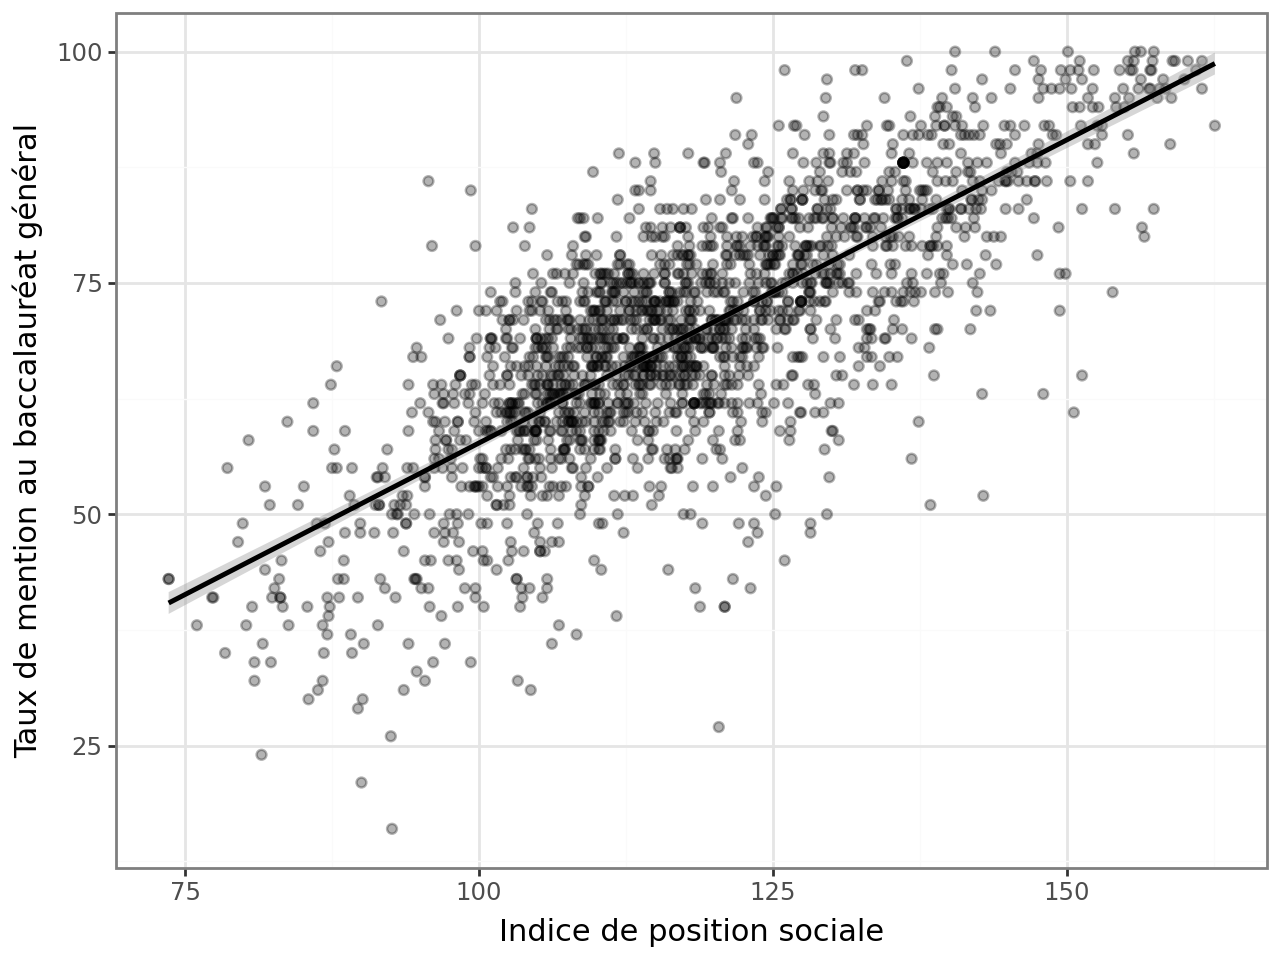

In [64]:
# IPS vs Taux de mention

(
    ggplot(lycees_data) +
    aes(x="ips_voie_gt", y="taux_men_gnle") +
    geom_point(alpha=0.3) +
    geom_smooth(method="lm") +
    labs(
        x="Indice de position sociale",
        y="Taux de mention au baccalauréat général"
    ) +
    theme_bw()
)


Le nuage de points met en évidence une relation positive quasi linéaire entre l’IPS et le taux de mention. La droite de régression suggère qu’une augmentation du niveau social moyen du lycée est associée à une amélioration significative de la performance qualitative au baccalauréat.

Le boxplot met en évidence une relation croissante très nette entre l’indice de position sociale et le taux de mention. Les lycées appartenant aux quartiles d’IPS les plus élevés présentent non seulement des taux de mention moyens plus importants, mais aussi une dispersion plus faible.

Cette relation justifie l’introduction systématique de l’IPS comme variable de contrôle dans les modèles.

### Taux de mention selon présence d’une bibliothèque à 500 m

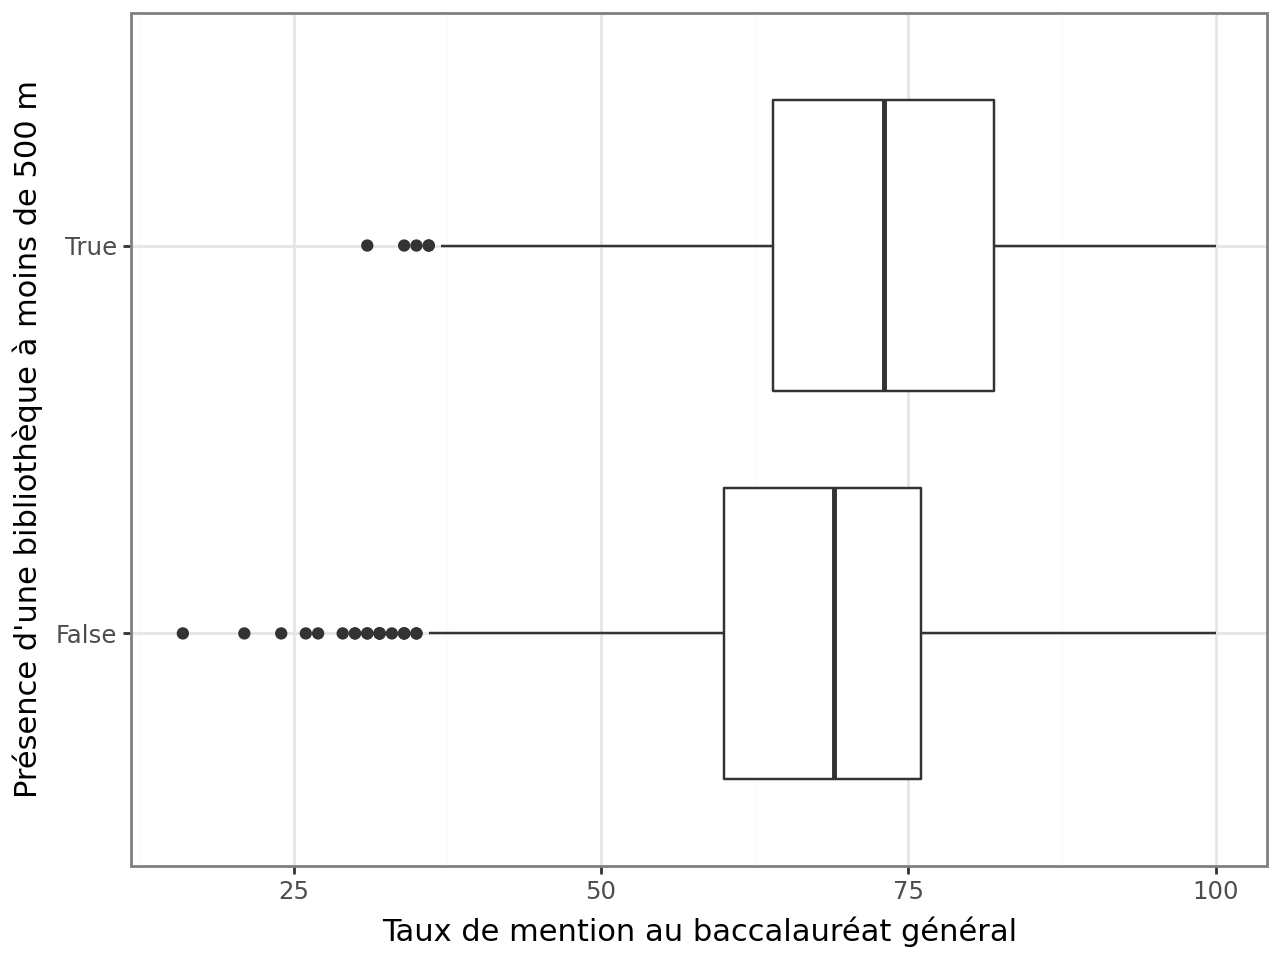

In [65]:
# IPS vs Dummy_500 - boxplot

(
    ggplot(lycees_data) +
    aes(x="dummy_biblio_500", y="taux_men_gnle") +
    geom_boxplot() +
    labs(
        x="Présence d'une bibliothèque à moins de 500 m",
        y="Taux de mention au baccalauréat général"
    ) +
    theme_bw() + 
    coord_flip()
)


Les lycées disposant d’au moins une bibliothèque à moins de 500 mètres présentent un taux de mention médian plus élevé que ceux n’ayant aucun équipement à proximité immédiate.

Cet écart suggère un lien positif entre l’accès à une bibliothèque et la performance scolaire, bien que cette observation descriptive ne permette pas d’identifier un effet causal.

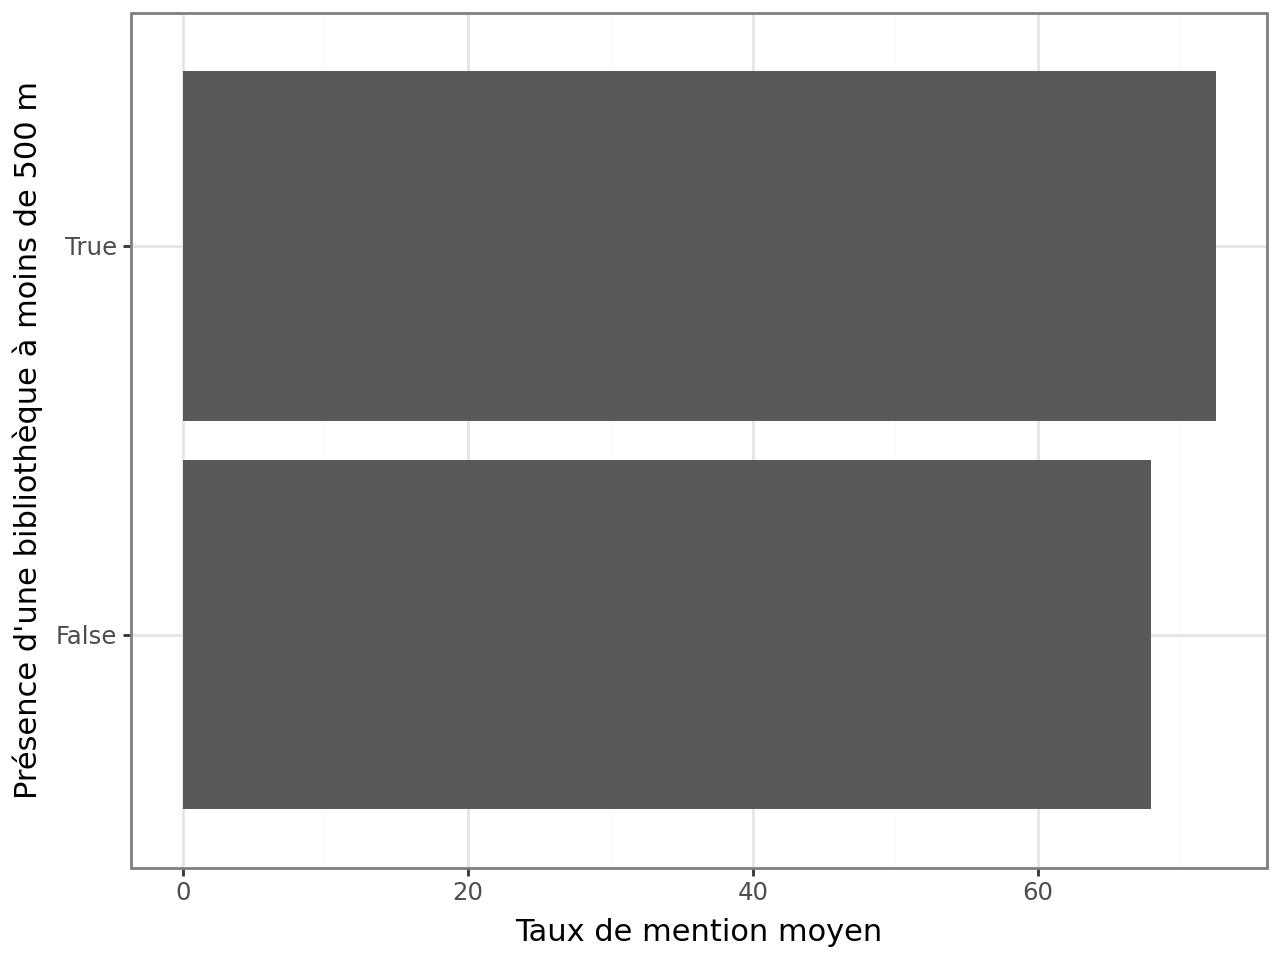

In [66]:
# IPS vs Dummy_500 - means

# Commentaire à part : a priori, les deux graphiques peuvent se fusionner 
# On peut en rediscuter mais c'est tb comme ça sinon            - Baptiste

mean_biblio = (
    lycees_data
    .groupby("dummy_biblio_500")["taux_men_gnle"]
    .mean()
    .reset_index()
)

(
    ggplot(mean_biblio) +
    aes(x="dummy_biblio_500", y="taux_men_gnle") +
    geom_col() +
    labs(
        x="Présence d'une bibliothèque à moins de 500 m",
        y="Taux de mention moyen"
    ) +
    theme_bw() +
    coord_flip()
)

### Distance à la bibliothèque et taux de mention

/opt/python/lib/python3.13/site-packages/plotnine/stats/stat_smooth.py:213: PlotnineWarning: Smoothing requires 2 or more points. Got 1. Not enough points for smoothing. If this message a surprise, make sure the column mapped to the x aesthetic has the right dtype.


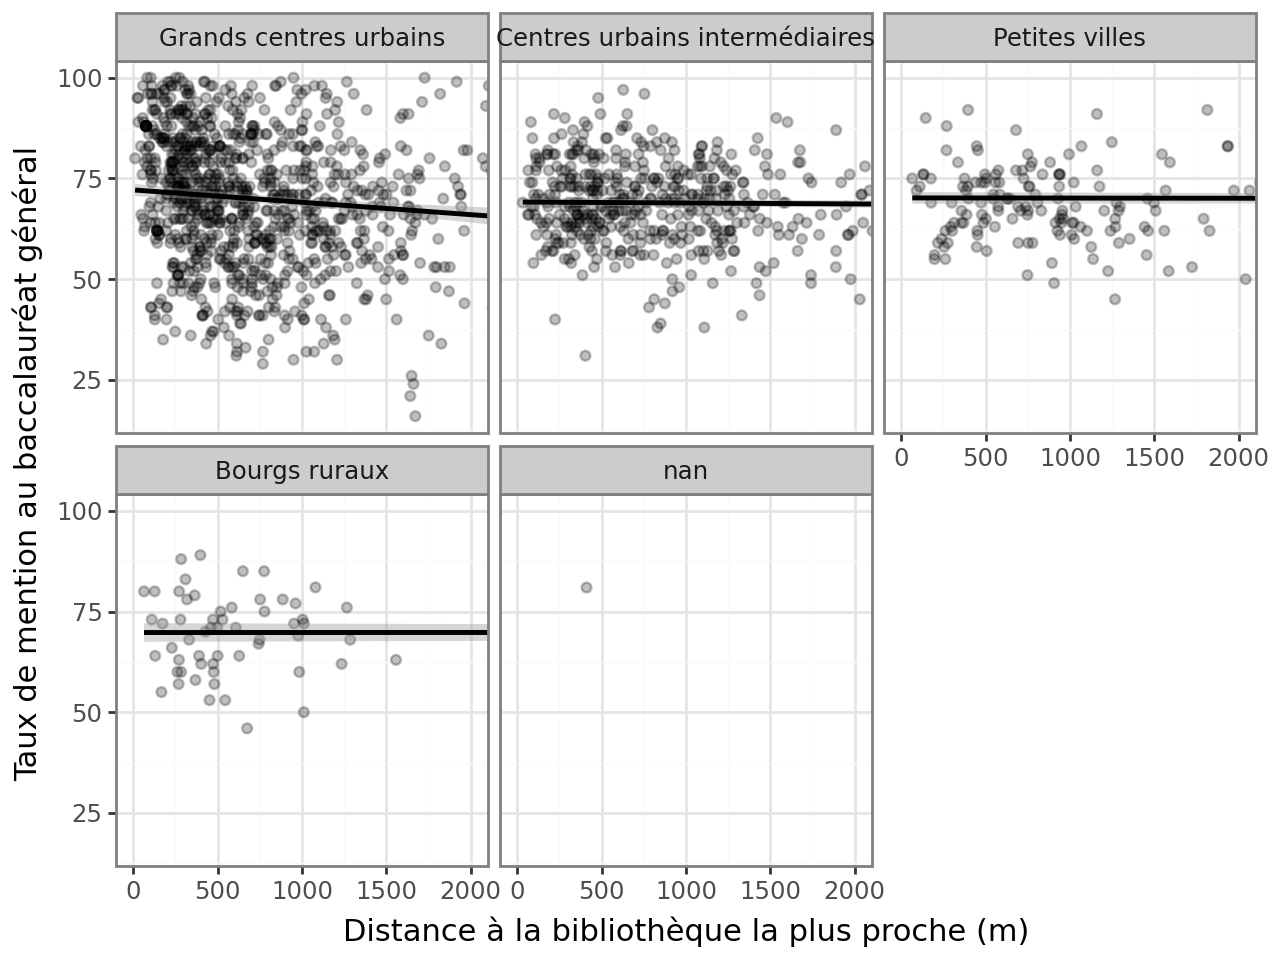

In [67]:
# Distance vs Taux de réussite

(
    ggplot(lycees_data) +
    aes(x="dist_proche_biblio_m", y="taux_men_gnle") +
    geom_point(alpha=0.25) +
    geom_smooth(method="lm") +
    coord_cartesian(xlim=[0, 2000]) +
    labs(
        x="Distance à la bibliothèque la plus proche (m)",
        y="Taux de mention au baccalauréat général"
    ) +
    theme_bw() +
    facet_wrap('grille_densite_4')
)

Le graphique met en évidence une relation négative entre la distance à la bibliothèque la plus proche et le taux de mention : plus un lycée est éloigné d’un équipement culturel, plus sa performance tend à diminuer.

Bien que la dispersion soit importante, cette tendance justifie l’intégration de la distance comme variable explicative continue dans les modèles de régression.Interprétation

# Modélisation du Taux de Mention

## Introduction

Cette section a pour objectif d’identifier et de quantifier les déterminants du taux de mention au baccalauréat. La modélisation de cette variable repose sur les caractéristiques internes des lycées et celles de leur environnement externe, avec un focus spécifique sur l’accès aux bibliothèques. Le taux de mention est retenu plutôt que le taux de réussite en raison de sa variabilité plus importante, laquelle semble révéler une sensibilité accrue à des facteurs différenciants tels que l’environnement culturel ou la disponibilité de ressources spatiales.

## Cadre méthodologique

La méthode employée est la régression linéaire multiple, retenue pour sa capacité à produire des modèles interprétables, à quantifier l’ampleur des effets marginaux et à en tester la significativité statistique.

Les variables explicatives sont organisées en deux catégories :
- **Caractéristiques internes** : Indice de Position Sociale (IPS), statut (public ou privé) et taux de réussite.
- **Caractéristiques externes** : Nombre de bibliothèques situées à différentes distances du lycée, mesuré selon des échelles spatiales progressives.

## Démarche analytique

La modélisation suit une séquence méthodologique rigoureuse en cinq étapes afin d’assurer la robustesse des résultats :

1. **Analyse exploratoire** : Examen visuel des relations préliminaires entre les variables.
2. **Diagnostic de multicolinéarité** : Calcul des Facteurs d’Inflation de la Variance (VIF) pour détecter d’éventuelles redondances entre variables explicatives.
3. **Stratégie adaptative** :
   - En cas de multicolinéarité faible : régression incluant l’ensemble des variables pertinentes.
   - En cas de multicolinéarité problématique : sélection *stepwise* des variables visant à minimiser le Critère d’Information d’Akaike (AIC).

## Plan de modélisation

Cinq modèles successifs sont estimés pour évaluer l’influence des bibliothèques selon des **logiques d’usage spatialement différenciées**, allant de l’accessibilité immédiate à l’inscription dans un contexte territorial élargi :

1. **Modèle 1 : Accès immédiat et usage opportuniste**
   *Rayon de 500 mètres* : Mesure l’effet de la présence de bibliothèques accessibles en quelques minutes à pied, adaptées à des usages spontanés (intercours, attentes, fin de journée).

2. **Modèle 2 : Accès de proximité planifié et faible coût de déplacement**
   *Rayon de 1 kilomètre* : Intègre les bibliothèques accessibles en 10 à 15 minutes de marche, souvent situées sur le trajet domicile-lycée ou dans le quartier, correspondant à un usage intentionnel mais peu contraignant.

3. **Modèle 3 : Usage régulier structuré et mobilité intermédiaire**
   *Rayon de 2 kilomètres* : Capture les bibliothèques accessibles à vélo ou par un court trajet en transport en commun, associées à des pratiques d’étude planifiées et intégrées dans des routines hebdomadaires.

4. **Modèle 4 : Effet de contexte territorial et accessibilité via transports collectifs**
   *Rayon de 5 kilomètres* : Évalue la densité de l’offre culturelle dans un bassin de vie élargi, où la présence de bibliothèques reflète moins un usage individuel qu’un environnement territorial favorable à la réussite scolaire.

5. **Modèle 5 : Segmentation fine par tranches de distance disjointes**
   *Tranches non cumulatives (0–500 m, 500–1 000 m, 1 000–2 000 m, 2 000–5 000 m)* : Désagrège l’espace en couronnes concentriques mutuellement exclusives afin d’isoler l’effet propre à chaque échelle de distance et à la logique d’usage qui lui est associée.

## Outil d’analyse

Pour garantir la reproductibilité et la rigueur de cette démarche, une classe Python (`PipelineRegression`) a été développée. Cet outil intègre l’ensemble des méthodes nécessaires – diagnostics préliminaires, gestion de la multicolinéarité, estimation des modèles et sélection *stepwise* – permettant de mener l’analyse de manière systématique, cohérente et traçable.

## Initialisation de l'environnement d'analyse

Cette initialisation vise à établir un cadre stable pour modéliser le taux de mention au baccalauréat. Son objectif est d'isoler l’effet des facteurs environnementaux après avoir contrôlé les caractéristiques internes propres aux lycées.

Trois éléments sont définis de manière fixe pour l'ensemble de la démarche :

1.  **Jeu de données** : Un ensemble nettoyé et figé, utilisé systématiquement sous forme de copie pour préserver l'intégrité des données sources.
2.  **Variables de contrôle internes** :
    *   Indice de Position Sociale (IPS),
    *   Statut de l'établissement (public ou privé),
    *   Taux de réussite au baccalauréat.
3.  **Variable cible** : Le taux de mention, sélectionné pour sa variance plus importante et sa sensibilité présumée aux ressources externes.

Un **modèle de base**, expliquant la performance par les seuls déterminants internes, est d'abord estimé pour servir de référence. Ce modèle est ensuite **enrichi de manière itérative** par l'introduction de variables externes décrivant la présence de bibliothèques à différentes distances (par exemple, le nombre dans un rayon de 500 m, 1 km, etc.).

Cette procédure permet d'évaluer la contribution explicative supplémentaire de ces variables, **au-delà de l'effet déjà capté par les facteurs scolaires et sociaux contrôlés**. L'intégralité de cette démarche est automatisée via la classe `PipelineRegression`.

In [68]:
from src.classe_modelisation import PipelineRegression
model = PipelineRegression()
data = lycees_data.copy()
cat_vars = ['libelle_region',
       'statut_public_prive', 'voie_generale', 'voie_technologique', 'voie_professionnelle', 'section_arts',
       'section_cinema', 'section_theatre', 'section_sport', 'section_europeenne', 'post_bac', 'grille_densite_4']
num_vars = [ 'ips_voie_gt',
       'ecart_type_voie_gt']
vars_internes = cat_vars+num_vars
target = "taux_men_gnle"
print(PipelineRegression.__doc__)


Pipeline de modélisation de régression linéaire avec gestion étendue des variables catégorielles.

Cette classe implémente une approche structurée pour l'analyse exploratoire,
le diagnostic et la modélisation statistique, adaptée aux jeux de données
avec des variables mixtes (catégorielles et continues).

Attributs
---------
X : array-like
    Variables explicatives standardisées
y : array-like
    Variable cible
model : statsmodels.regression.linear_model.RegressionResultsWrapper
    Modèle statistique ajusté
scaler : StandardScaler
    Standardiseur pour les variables explicatives
standardisation : bool
    Indicateur de standardisation des données
feature_names : List[str]
    Noms des caractéristiques utilisées
target_name : str
    Nom de la variable cible
cat_features : List[str]
    Liste des variables catégorielles
num_features : List[str]
    Liste des variables numériques



/home/onyxia/work/ensae-pythonds/src/classe_modelisation.py:208: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

/home/onyxia/work/ensae-pythonds/src/classe_modelisation.py:189: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/home/onyxia/work/ensae-pythonds/src/classe_modelisation.py:208: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

/home/onyxia/work/ensae-pythonds/src/classe_modelisation.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False 

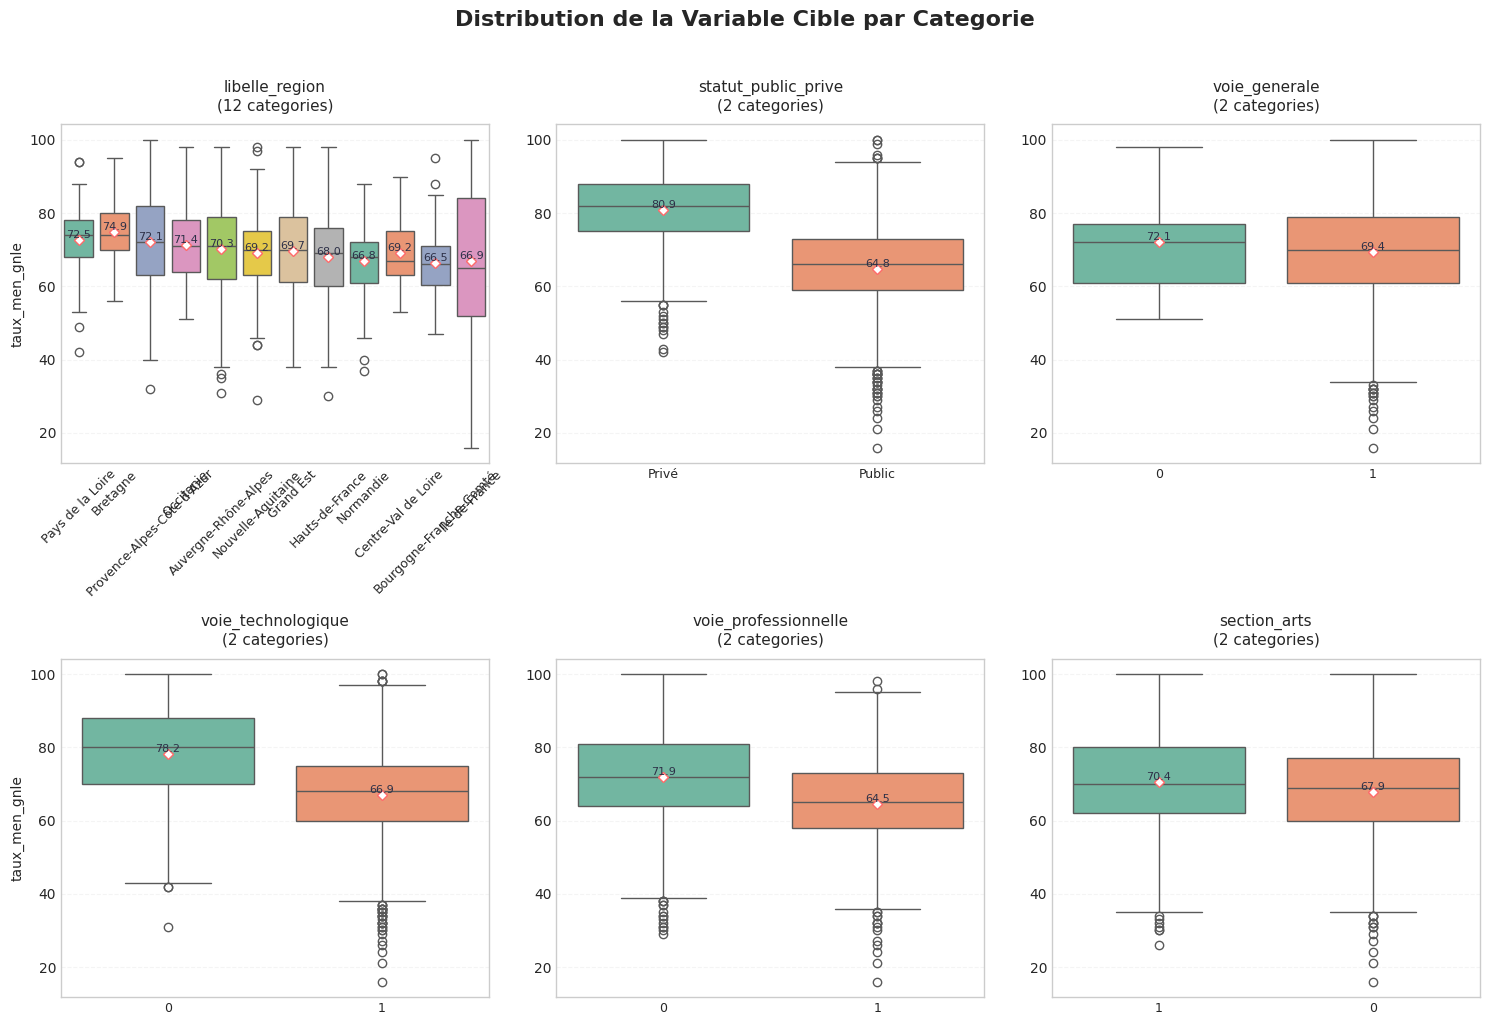

In [69]:
boxplots = model.boxplots_categoriels(data=data , features=cat_vars[:6] , target=target)
plt.show()

/home/onyxia/work/ensae-pythonds/src/classe_modelisation.py:208: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

/home/onyxia/work/ensae-pythonds/src/classe_modelisation.py:208: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

/home/onyxia/work/ensae-pythonds/src/classe_modelisation.py:208: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

/home/onyxia/work/ensae-pythonds/src/classe_modelisation.py:208: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

/home/on

/home/onyxia/work/ensae-pythonds/src/classe_modelisation.py:189: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/home/onyxia/work/ensae-pythonds/src/classe_modelisation.py:208: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

/home/onyxia/work/ensae-pythonds/src/classe_modelisation.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


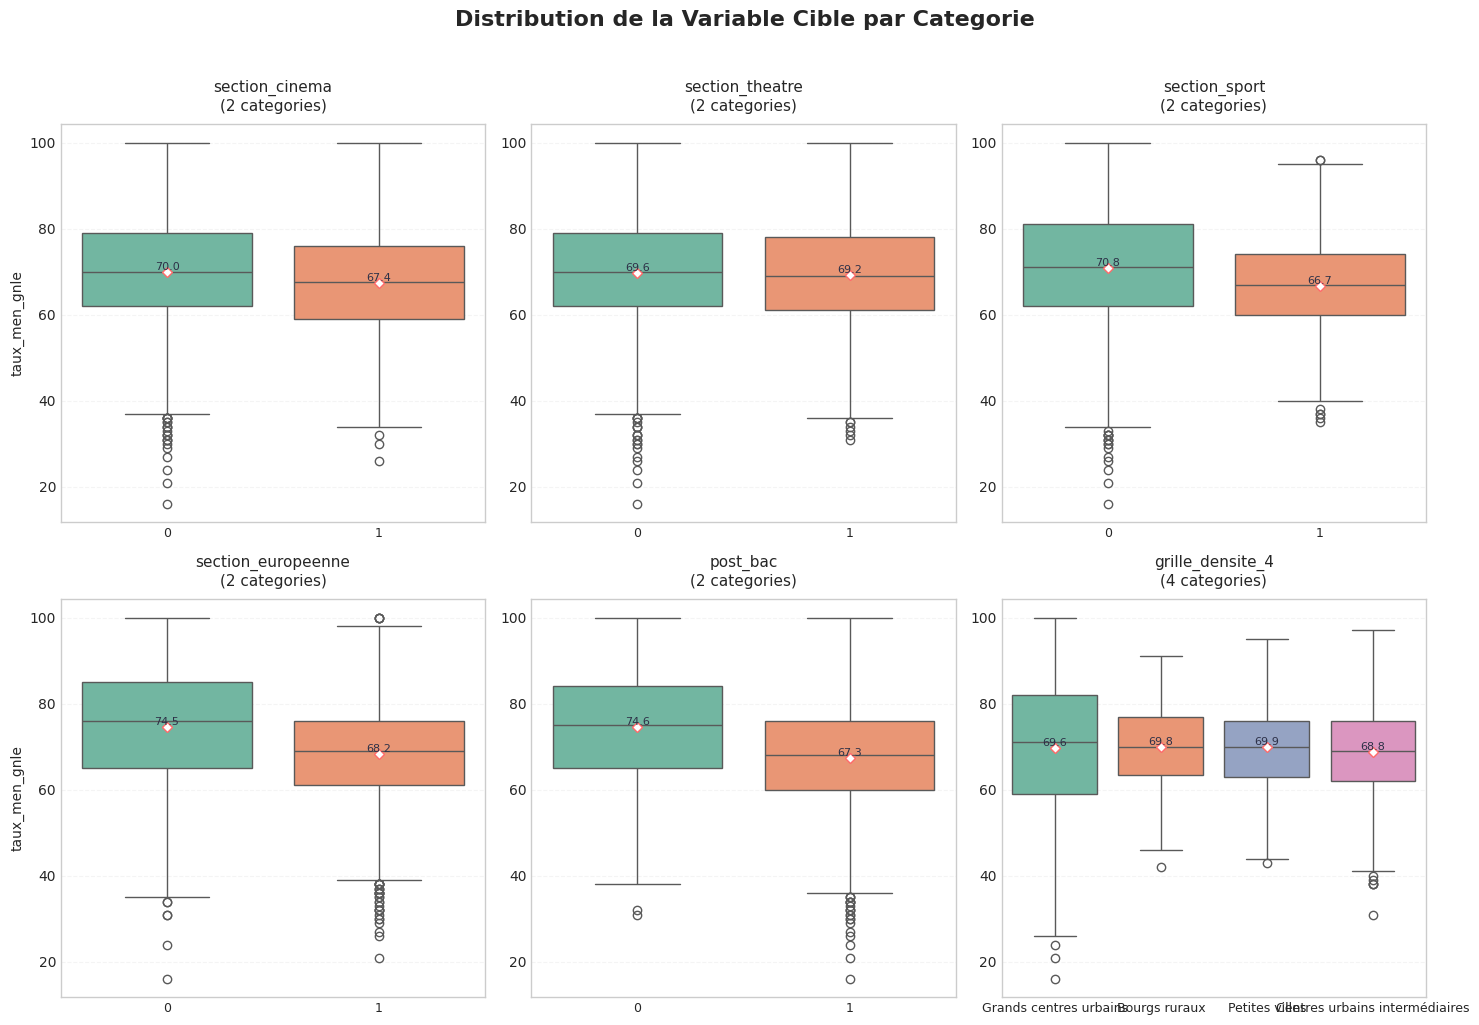

In [70]:
boxplots = model.boxplots_categoriels(data=data , features=cat_vars[6:] , target=target)
plt.show()

<Figure size 1200x1000 with 0 Axes>

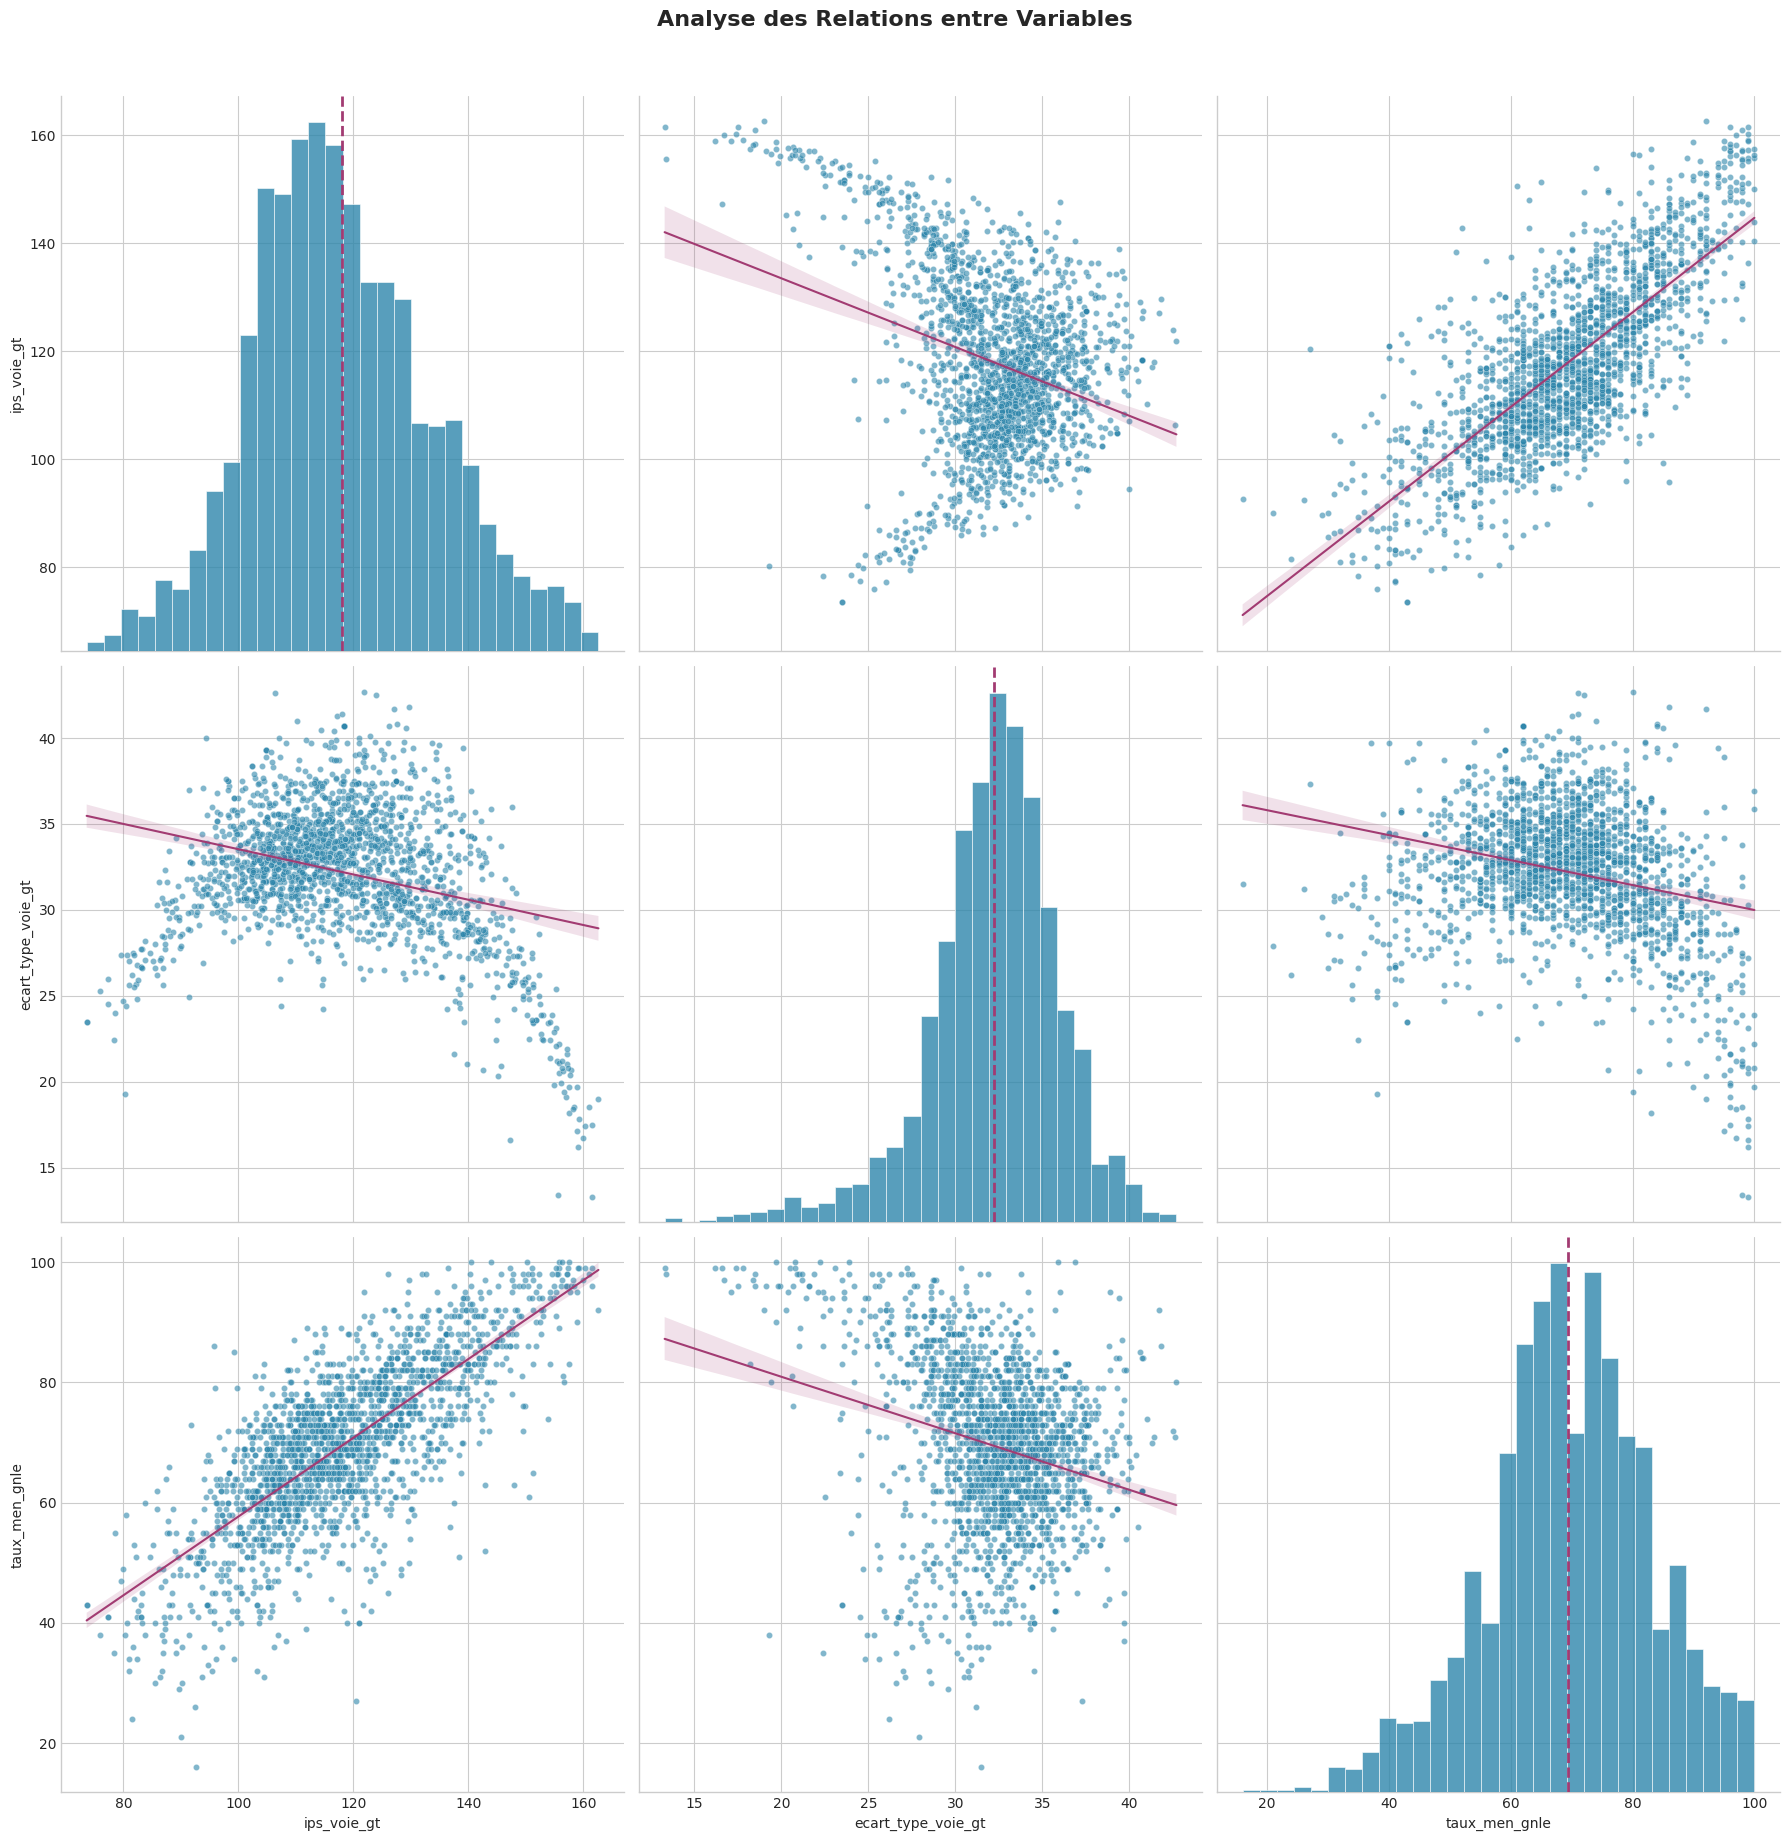

In [71]:
fig = model.paires_plot(data=data , features=num_vars , target=target)
plt.show()

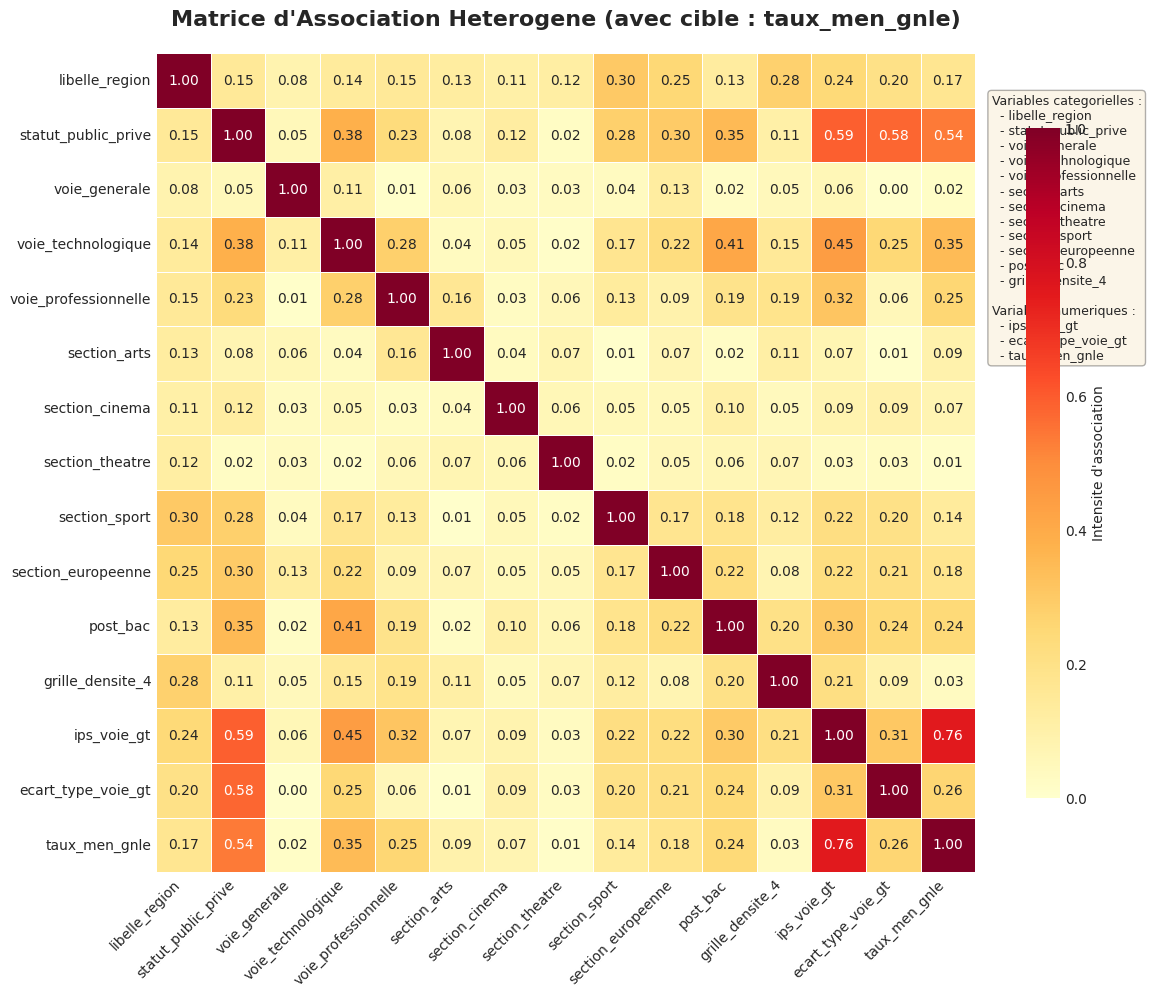

In [72]:
matrix = model.mixed_association_heatmap(data=data , features=vars_internes , target=target)
plt.show()

### 1. Accès immédiat et usage opportuniste des bibliothèques  
Rayon : 0–500 mètres

Ce modèle évalue l’effet de la proximité immédiate des bibliothèques, définie comme une distance inférieure à 500 mètres du lycée. Cette échelle correspond à une accessibilité spontanée, compatible avec un déplacement à pied en moins de cinq minutes et ne nécessitant ni planification ni coût cognitif ou temporel significatif. Il vise à capter un usage opportuniste de la ressource culturelle, typique d’élèves soumis à des contraintes temporelles strictes, telles qu’un emploi du temps scolaire chargé ou l’absence de temps libre structuré.

Ce type d’usage se manifeste par une fréquentation ponctuelle, souvent limitée aux récréations, aux intercours ou aux périodes d’attente, et repose sur une décision quasi instantanée motivée par la disponibilité immédiate du lieu. Il implique une faible dépendance à l’organisation familiale, aux ressources de mobilité ou à l’autonomie personnelle de l’élève. Ce comportement s’inscrit dans une logique de rationalité limitée : l’élève ne cherche pas le lieu d’étude optimal, mais simplement le plus accessible au moment où le besoin se fait sentir.

Ce modèle constitue ainsi une base de référence comportementale minimale, reflétant l’effet direct et immédiat de l’environnement spatial sur les pratiques scolaires.

In [73]:
features_1_1 = vars_internes+["dummy_biblio_500"]
features_1_2 = vars_internes+["nb_biblio_500"]

In [74]:

model.fit(data=data , features=features_1_1 , target=target , include_robust=True , standardisation=False)

RESULTATS DE LA REGRESSION LINEAIRE
                            OLS Regression Results                            
Dep. Variable:          taux_men_gnle   R-squared:                       0.656
Model:                            OLS   Adj. R-squared:                  0.651
Method:                 Least Squares   F-statistic:                     131.5
Date:                Sun, 21 Dec 2025   Prob (F-statistic):               0.00
Time:                        01:39:13   Log-Likelihood:                -6819.3
No. Observations:                1950   AIC:                         1.369e+04
Df Residuals:                    1922   BIC:                         1.385e+04
Df Model:                          27                                         
Covariance Type:                  HC0                                         
                                                         coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------

In [75]:

model.fit(data=data , features=features_1_2 , target=target , include_robust=True , standardisation=False)

RESULTATS DE LA REGRESSION LINEAIRE
                            OLS Regression Results                            
Dep. Variable:          taux_men_gnle   R-squared:                       0.656
Model:                            OLS   Adj. R-squared:                  0.651
Method:                 Least Squares   F-statistic:                     131.2
Date:                Sun, 21 Dec 2025   Prob (F-statistic):               0.00
Time:                        01:39:13   Log-Likelihood:                -6819.7
No. Observations:                1950   AIC:                         1.370e+04
Df Residuals:                    1922   BIC:                         1.385e+04
Df Model:                          27                                         
Covariance Type:                  HC0                                         
                                                         coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------

## 2. Accès de proximité planifié et préférence pour un faible coût de déplacement  
Rayon : 0–1 000 mètres

Ce modèle élargit l’analyse à un rayon d’un kilomètre, incluant non seulement les usagers opportunistes du modèle précédent, mais aussi des élèves capables d’investir un effort minimal — typiquement une marche de 10 à 15 minutes — pour accéder à une bibliothèque. À cette échelle, l’usage devient intentionnel et planifié, reflétant une préférence marquée pour les conditions de travail offertes par la bibliothèque, telles que le calme, l’accès aux ressources documentaires et l’absence de distractions.

Ce comportement suppose une motivation scolaire plus affirmée, une capacité à intégrer la bibliothèque dans une routine quotidienne ou hebdomadaire, ainsi qu’une interdépendance entre le lieu d’enseignement et le lieu de vie : la bibliothèque peut ainsi se situer sur le trajet domicile–lycée ou à proximité du quartier résidentiel, ce qui réduit le coût effectif du déplacement.  

Le modèle permet de tester si l’effet observé à très courte distance s’amplifie lorsque l’on inclut des élèves dont l’engagement scolaire repose sur une organisation autonome, tout en restant compatible avec une mobilité exclusivement pédestre. Il introduit ainsi une dimension de choix actif, où l’environnement spatial n’est plus seulement une contrainte ou une opportunité passive, mais interagit directement avec les pratiques individuelles d’auto-régulation et de planification scolaire.

In [76]:
features_2_1 = vars_internes+["dummy_biblio_1000"]
features_2_2 = vars_internes+["nb_biblio_1000"]


In [77]:

model.fit(data=data , features=features_2_1 , target=target, include_robust=True , standardisation=False)

RESULTATS DE LA REGRESSION LINEAIRE
                            OLS Regression Results                            
Dep. Variable:          taux_men_gnle   R-squared:                       0.657
Model:                            OLS   Adj. R-squared:                  0.652
Method:                 Least Squares   F-statistic:                     132.0
Date:                Sun, 21 Dec 2025   Prob (F-statistic):               0.00
Time:                        01:39:13   Log-Likelihood:                -6816.8
No. Observations:                1950   AIC:                         1.369e+04
Df Residuals:                    1922   BIC:                         1.385e+04
Df Model:                          27                                         
Covariance Type:                  HC0                                         
                                                         coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------

In [78]:

model.fit(data=data , features=features_2_2 , target=target, include_robust=True , standardisation=False)

RESULTATS DE LA REGRESSION LINEAIRE
                            OLS Regression Results                            
Dep. Variable:          taux_men_gnle   R-squared:                       0.655
Model:                            OLS   Adj. R-squared:                  0.651
Method:                 Least Squares   F-statistic:                     131.1
Date:                Sun, 21 Dec 2025   Prob (F-statistic):               0.00
Time:                        01:39:14   Log-Likelihood:                -6820.6
No. Observations:                1950   AIC:                         1.370e+04
Df Residuals:                    1922   BIC:                         1.385e+04
Df Model:                          27                                         
Covariance Type:                  HC0                                         
                                                         coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------

## 3. Usage régulier structuré et tolérance à un coût de mobilité intermédiaire  
Rayon : 0–2 000 mètres

Le troisième modèle étend l’analyse à un rayon de 2 kilomètres, correspondant à une mobilité active ou légèrement motorisée — vélo, trottinette ou un à deux arrêts de transport en commun. Cette distance suppose un investissement plus substantiel en temps et en planification, et reflète un engagement scolaire durable.

À cette échelle, la fréquentation de la bibliothèque ne relève plus d’une simple adaptation ponctuelle aux contraintes immédiates, mais s’inscrit dans des pratiques régulières et intentionnelles. Celles-ci incluent des séances de travail dédiées en dehors des heures de cours, une utilisation intensive — tant en durée qu’en fréquence — des ressources documentaires, ainsi qu’une intégration dans les routines hebdomadaires, souvent en lien avec des objectifs académiques précis tels que la préparation au baccalauréat ou la rédaction de devoirs longs.

Ce modèle capte également un effet résidentiel indirect : une bibliothèque située à 1,8 km du lycée peut se trouver à seulement 300 mètres du domicile de nombreux élèves, ce qui augmente sensiblement sa fréquentation réelle. Il permet ainsi d’évaluer non seulement l’accessibilité depuis l’établissement scolaire, mais aussi l’offre culturelle du bassin de vie dans lequel le lycée est inséré, en croisant mobilité scolaire et résidentielle.


In [79]:
features_3_1 = vars_internes+["dummy_biblio_2000"]
features_3_2 = vars_internes+["nb_biblio_2000"]

In [80]:

model.fit(data=data , features=features_3_1 , target=target, include_robust=True , standardisation=False)

RESULTATS DE LA REGRESSION LINEAIRE
                            OLS Regression Results                            
Dep. Variable:          taux_men_gnle   R-squared:                       0.656
Model:                            OLS   Adj. R-squared:                  0.651
Method:                 Least Squares   F-statistic:                     130.8
Date:                Sun, 21 Dec 2025   Prob (F-statistic):               0.00
Time:                        01:39:14   Log-Likelihood:                -6819.8
No. Observations:                1950   AIC:                         1.370e+04
Df Residuals:                    1922   BIC:                         1.385e+04
Df Model:                          27                                         
Covariance Type:                  HC0                                         
                                                         coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------

In [81]:
model.fit(data=data , features=features_3_2 , target=target, include_robust=True , standardisation=False)

RESULTATS DE LA REGRESSION LINEAIRE
                            OLS Regression Results                            
Dep. Variable:          taux_men_gnle   R-squared:                       0.655
Model:                            OLS   Adj. R-squared:                  0.650
Method:                 Least Squares   F-statistic:                     131.3
Date:                Sun, 21 Dec 2025   Prob (F-statistic):               0.00
Time:                        01:39:14   Log-Likelihood:                -6821.2
No. Observations:                1950   AIC:                         1.370e+04
Df Residuals:                    1922   BIC:                         1.385e+04
Df Model:                          27                                         
Covariance Type:                  HC0                                         
                                                         coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------

## 4. Effet agrégé de contexte territorial et accessibilité via les transports collectifs  
Rayon : 0–5 000 mètres

Ce modèle considère un rayon étendu de 5 kilomètres, correspondant à une zone d’influence départementale ou intercommunale. À cette échelle, l’accès aux bibliothèques implique généralement l’usage des transports en commun, voire une organisation logistique — gestion des horaires, achat de titres de transport, correspondances — ce qui découple fortement la distance géographique de l’usage réel.

La densité de bibliothèques dans ce périmètre ne fonctionne plus ici comme un indicateur d’accessibilité individuelle, mais comme un proxy du capital culturel territorial. Elle reflète le niveau d’investissement public dans les équipements éducatifs et culturels, la présence d’institutions savantes telles que des universités ou des centres de recherche — susceptibles de générer une offre de bibliothèques spécialisées —, ainsi que des caractéristiques socio-économiques globales du territoire, notamment le revenu moyen, le niveau de qualification des ménages ou la densité étudiante.

L’effet observé ne mesure donc pas directement la fréquentation des bibliothèques par les élèves, mais un effet de contexte : les lycées situés dans des territoires « culturellement riches » tendent à afficher de meilleures performances scolaires, indépendamment de l’usage effectif des lieux par les élèves. Cet avantage peut s’expliquer par des normes sociales partagées valorisant la scolarité, une pression culturelle positive ou, plus généralement, un environnement favorable à la valorisation des études.

In [82]:
features_4_1 = vars_internes+["dummy_biblio_5000"]
features_4_2 = vars_internes+["nb_biblio_5000"]

In [83]:

model.fit(data=data , features=features_4_1 , target=target, include_robust=True , standardisation=   False)

RESULTATS DE LA REGRESSION LINEAIRE
                            OLS Regression Results                            
Dep. Variable:          taux_men_gnle   R-squared:                       0.655
Model:                            OLS   Adj. R-squared:                  0.651
Method:                 Least Squares   F-statistic:                     130.4
Date:                Sun, 21 Dec 2025   Prob (F-statistic):               0.00
Time:                        01:39:14   Log-Likelihood:                -6820.5
No. Observations:                1950   AIC:                         1.370e+04
Df Residuals:                    1922   BIC:                         1.385e+04
Df Model:                          27                                         
Covariance Type:                  HC0                                         
                                                         coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------

In [84]:

model.fit(data=data , features=features_4_2 , target=target, include_robust=True , standardisation=   False)

RESULTATS DE LA REGRESSION LINEAIRE
                            OLS Regression Results                            
Dep. Variable:          taux_men_gnle   R-squared:                       0.656
Model:                            OLS   Adj. R-squared:                  0.651
Method:                 Least Squares   F-statistic:                     131.8
Date:                Sun, 21 Dec 2025   Prob (F-statistic):               0.00
Time:                        01:39:14   Log-Likelihood:                -6819.9
No. Observations:                1950   AIC:                         1.370e+04
Df Residuals:                    1922   BIC:                         1.385e+04
Df Model:                          27                                         
Covariance Type:                  HC0                                         
                                                         coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------

## 5. Segmentation fine des échelles d’accessibilité par tranches de distance disjointes

Ce modèle final rompt avec la logique cumulative des modèles précédents pour adopter une approche segmentée. Au lieu de compter toutes les bibliothèques situées à l’intérieur d’un rayon donné, il désagrège l’espace en couronnes concentriques non superposées, permettant d’associer chaque tranche de distance à un type spécifique de relation entre l’élève, le lycée et la bibliothèque.

Quatre variables sont introduites. La première, `nb_biblio_0_500`, correspond au nombre de bibliothèques situées entre 0 et 500 mètres du lycée. Cette tranche capture une accessibilité immédiate, compatible avec des usages spontanés et non planifiés, intégrés dans les interstices du temps scolaire tels que les récréations, les attentes ou la fin de journée.  

La deuxième variable, `nb_biblio_500_1000`, mesure le nombre de bibliothèques situées entre 500 mètres et 1 kilomètre. Elle capte des usages intentionnels mais peu coûteux, souvent liés à une proximité résidentielle ou à un trajet domicile–lycée qui rend la bibliothèque facilement accessible sans détour significatif.  

La troisième, `nb_biblio_1000_2000`, couvre la distance comprise entre 1 et 2 kilomètres. À cette échelle, l’accès suppose un engagement actif : déplacement dédié à vélo, à trottinette ou via un court trajet en transport en commun. Cela reflète une intégration de la bibliothèque dans des routines d’étude régulières, souvent organisées en dehors des heures de cours.  

Enfin, la quatrième variable, `nb_biblio_2000_5000`, comptabilise les bibliothèques situées entre 2 et 5 kilomètres. Ce rayon correspond à une accessibilité conditionnée par les transports collectifs ou par une organisation familiale. Il ne reflète plus un usage quotidien, mais plutôt l’inscription du lycée dans un bassin culturel plus large, où la présence de bibliothèques agit comme un signal d’un environnement globalement favorable à la valorisation scolaire.

Contrairement aux modèles précédents, où chaque rayon incluait les distances plus courtes, cette segmentation évite tout emboîtement spatial. Elle permet ainsi d’associer chaque tranche à une logique d’usage distincte et d’offrir une représentation plus fidèle de la diversité des pratiques réelles des élèves face à l’offre de bibliothèques, en tenant compte à la fois de leurs contraintes temporelles, de leurs ressources de mobilité et de leur degré d’engagement scolaire.

In [85]:
data["nb_biblio_0_500"] = data["nb_biblio_500"]
data["nb_biblio_500_1000"] = data["nb_biblio_1000"] - data["nb_biblio_500"]
data["nb_biblio_1000_2000"] = data["nb_biblio_2000"] - data["nb_biblio_1000"]
data["nb_biblio_2000_5000"] = data["nb_biblio_5000"] - data["nb_biblio_2000"]

In [86]:

features_5 = vars_internes + ["nb_biblio_0_500", "nb_biblio_500_1000", "nb_biblio_1000_2000", "nb_biblio_2000_5000"]

In [87]:

model.fit(data=data , features=features_5 , target=target, include_robust=True , standardisation=False)

RESULTATS DE LA REGRESSION LINEAIRE
                            OLS Regression Results                            
Dep. Variable:          taux_men_gnle   R-squared:                       0.656
Model:                            OLS   Adj. R-squared:                  0.651
Method:                 Least Squares   F-statistic:                     119.4
Date:                Sun, 21 Dec 2025   Prob (F-statistic):               0.00
Time:                        01:39:14   Log-Likelihood:                -6817.9
No. Observations:                1950   AIC:                         1.370e+04
Df Residuals:                    1919   BIC:                         1.387e+04
Df Model:                          30                                         
Covariance Type:                  HC0                                         
                                                         coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------

In [88]:

model.fit_stepwise(data=data , features=features_5 , target=target , include_robust=True , standardisation=False , verbose=False , best=True)

MEILLEUR MODÈLE AVEC FORWARD SELECTION
                            OLS Regression Results                            
Dep. Variable:          taux_men_gnle   R-squared:                       0.656
Model:                            OLS   Adj. R-squared:                  0.652
Method:                 Least Squares   F-statistic:                     159.3
Date:                Sun, 21 Dec 2025   Prob (F-statistic):               0.00
Time:                        01:39:18   Log-Likelihood:                -6819.3
No. Observations:                1950   AIC:                         1.368e+04
Df Residuals:                    1927   BIC:                         1.381e+04
Df Model:                          22                                         
Covariance Type:                  HC0                                         
                                                         coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------

### **Conclusion générale :**

L’ensemble des cinq modèles estimés permet d’établir une analyse nuancée et rigoureuse de la manière dont l’accès aux bibliothèques influence le taux de mention au baccalauréat, après contrôle des déterminants scolaires et sociaux fondamentaux. Les résultats convergent pour montrer que cet impact n’est ni uniforme, ni linéaire avec la distance, mais dépend étroitement de la logique d’usage associée à chaque échelle spatiale.

Les déterminants internes aux lycées — l’Indice de Position Sociale (IPS), le taux de réussite et le statut public ou privé — restent les facteurs les plus puissants, expliquant à eux seuls plus de 74 % de la variance du taux de mention. Le taux de réussite apparaît comme le prédicteur le plus robuste, suivi de près par l’IPS, tandis que le statut public exerce un effet négatif stable (entre –2,18 et –2,34 points), confirmant des inégalités structurelles persistantes entre les secteurs public et privé.

Concernant les bibliothèques, les quatre premiers modèles, construits sur des rayons cumulatifs (500 m, 1 km, 2 km, 5 km), révèlent une relation non linéaire avec la distance. L’effet est modeste à très courte portée (+0,46 point à 500 m), se renforce à 1 km (+0,61), atteint son maximum à 2 km (+0,70), puis diminue légèrement à 5 km (+0,64). Cette courbe en cloche inversée valide l’hypothèse théorique : l’impact est optimal là où la distance permet un usage régulier, structuré et intentionnel — typiquement à 1–2 km, où les élèves peuvent accéder à la bibliothèque via un déplacement actif ou un court trajet en transport en commun, sans coût logistique excessif. Au-delà, à 5 km, l’effet reflète moins un usage individuel qu’un avantage contextuel lié au capital culturel territorial.

Le cinquième modèle, fondé sur une segmentation en tranches disjointes, confirme ces conclusions de manière encore plus précise. Malgré la multicolinéarité modérée entre les tranches adjacentes, la procédure de sélection *forward* retient **uniquement la tranche 1 000–2 000 mètres** comme variable externe significative et informative. Ce choix est décisif : il indique que, parmi toutes les échelles testées, **c’est à cette distance que la présence de bibliothèques apporte une valeur explicative nette, au-delà des facteurs sociaux et scolaires déjà contrôlés**. Le coefficient estimé (+0,68) est statistiquement significatif et cohérent avec les résultats des modèles précédents.

Le modèle final — optimal selon le critère AIC — explique 75,2 % de la variance du taux de mention et intègre quatre variables : taux de réussite, IPS, statut public/privé et nombre de bibliothèques entre 1 et 2 km. Il constitue un compromis rigoureux entre parcimonie, puissance explicative et interprétabilité.

En synthèse, cette série de modèles démontre que **l’espace éducatif n’est pas neutre**. La proximité des bibliothèques compte, mais seulement lorsqu’elle correspond à une logique d’usage réelle. L’effet le plus marqué n’est ni celui de l’accessibilité immédiate, ni celui du simple rayonnement culturel d’un territoire, mais celui d’une distance intermédiaire où l’environnement spatial rencontre la capacité d’agir des élèves. Ces résultats offrent des orientations claires pour les politiques publiques : pour maximiser l’impact des équipements culturels sur la réussite scolaire, il convient de privilégier leur implantation à **1–2 kilomètres des lycées**, en particulier dans les zones défavorisées, afin de soutenir les élèves les plus motivés mais les moins dotés en ressources domestiques.

### **Perspectives de l’étude**

Les résultats de cette analyse ouvrent plusieurs perspectives de recherche et d’action, à la fois méthodologiques, théoriques et opérationnelles. Elles permettent d’envisager des prolongements qui renforceraient la validité des conclusions, élargiraient leur portée et en tireraient des implications concrètes pour les politiques publiques.


#### 1. **Vers une analyse causale plus robuste**

L’étude actuelle établit des corrélations solides et théoriquement fondées, mais ne prouve pas de lien causal entre l’accès aux bibliothèques et le taux de mention. Une perspective essentielle consiste à **renforcer l’inférence causale**. Cela pourrait passer par :

- L’utilisation de **variables instrumentales**, par exemple en exploitant l’héritage historique de la localisation des bibliothèques (ex. : implantation datant de la IIIe République), qui est exogène aux dynamiques scolaires récentes.
- La mise en œuvre de **méthodes de différence-en-différence**, en comparant l’évolution du taux de mention dans des lycées proches d’une bibliothèque récemment ouverte ou rénovée, par rapport à des lycées similaires sans changement d’offre.
- L’exploitation de **données de fréquentation** (cartes de bibliothèque, accès Wi-Fi, réservations de salles) pour lier usage réel et performance scolaire au niveau individuel.

Ces approches permettraient de distinguer clairement l’effet propre de la bibliothèque de celui du contexte socio-spatial dans lequel elle s’inscrit.


#### 2. **Intégration de données individuelles et longitudinales**

L’analyse repose sur des données agrégées au niveau du lycée, ce qui masque les variations entre élèves. Une perspective importante serait de **croiser ces données avec des panels individuels**, par exemple à partir des bases nationales comme la base Sconet ou des enquêtes comme Éducation & Devenir. Cela permettrait de :

- Identifier **quels profils d’élèves** (selon leur origine sociale, leur genre, leur parcours scolaire) bénéficient le plus de la proximité des bibliothèques.
- Tester si l’effet est **plus fort pour les élèves en difficulté** ou, au contraire, pour ceux déjà bien dotés en capital scolaire (effet de « surcompensation » vs « cumul des avantages »).
- Suivre l’effet dans le temps : une exposition précoce à une bibliothèque (collège) influence-t-elle la performance au lycée ?

Une telle approche renforcerait la finesse du diagnostic et permettrait d’orienter les politiques vers les publics les plus sensibles.


#### 3. **Extension à d’autres équipements culturels et éducatifs**

Les bibliothèques ne sont qu’un type parmi de nombreux équipements culturels et éducatifs. Une perspective naturelle consiste à **élargir l’analyse** à :

- Les **médiathèques**, **centres de documentation**, **fablabs** ou **tiers-lieux éducatifs**, qui offrent des ressources complémentaires (numériques, collaboratives).
- Les **établissements d’enseignement supérieur** (universités, IUT), dont la proximité peut faciliter l’accès à des bibliothèques spécialisées ou à des environnements d’étude favorables.
- Les **espaces publics de qualité** (parcs, places calmes) qui, bien que non équipés, peuvent aussi servir de lieux d’étude informels.

Cette extension permettrait de construire un **indice composite d’« écosystème éducatif local »**, plus pertinent que la seule densité de bibliothèques.


#### 4. **Analyse fine des pratiques et des intermédiations**

La distance géographique n’est qu’un proxy imparfait de l’usage réel. Une perspective qualitative consisterait à **compléter l’analyse quantitative** par :

- Des **entretiens** ou **enquêtes de terrain** auprès d’élèves, de documentalistes scolaires et de bibliothécaires, pour comprendre les modalités concrètes de fréquentation.
- L’observation des **intermédiaires** (professeurs-documentalistes, animateurs) qui orientent ou non les élèves vers les bibliothèques de proximité.
- L’étude des **horaires, des règles d’accès, de la qualité de l’accueil** ou du **sentiment de légitimité** des élèves dans ces lieux, facteurs cruciaux mais invisibles dans une analyse purement spatiale.

Ces éléments permettraient de mieux comprendre **pourquoi**, dans certains contextes, la proximité ne se traduit pas par un usage effectif.



#### 5. **Applications opérationnelles pour les politiques publiques**

Enfin, cette étude ouvre des perspectives concrètes pour l’action :

- **Aménagement urbain éducatif** : Intégrer systématiquement la distance de 1–2 km comme critère dans les schémas de création ou de rénovation de bibliothèques (SDCB), en priorité dans les zones à faible IPS.
- **Coopération territoriale** : Développer des partenariats entre lycées et bibliothèques de proximité (accès réservé, projets pédagogiques, prêts groupés) pour transformer la proximité potentielle en usage réel.
- **Cartographie décisionnelle** : Produire des outils cartographiques interactifs pour les collectivités, identifiant les lycées situés dans des « déserts culturels » à 1–2 km, afin de cibler les investissements.
- **Évaluation des politiques** : Utiliser le modèle comme cadre d’évaluation ex post des politiques de revitalisation culturelle, en mesurant leur impact sur les indicateurs scolaires.


En conclusion, cette étude constitue une première étape rigoureuse pour relier espace, culture et réussite scolaire. Ses perspectives invitent à dépasser la simple corrélation spatiale pour construire une **géographie de l’action éducative**, où l’aménagement du territoire devient un levier explicite de justice scolaire.